<a href="https://colab.research.google.com/github/izzettinalhalil/ModRes_ML_Framework/blob/main/ModRes_ML_framework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Ml framework for predicting



#Torsional irregularity coefficient, Fundamental period and MPMR
#using Mod_Res databse

---




## *I. Data Preparation*


In [ ]:
#load the required library
import matplotlib
import numpy as np
import pandas as pd
import tensorflow as tf
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

In [ ]:

# load data and arrange into Pandas dataframe
df = read_csv("ModRes_database.csv", delim_whitespace=False, header=None)
feature_names = ['Ecc','Ecc_w_tar', 'Ecc_w_ort', 'A_tar', 'A_ort',
                 'N_spans', 'I_sw', 'H','Beam_sec','Col_sec','SDs', 'SD1','Torsion', 'Period', 'MPMR']

df.columns = feature_names
print("############################################################################")
print("The first five rows of the data is printed below:",df.head())
print("############################################################################")
print("Statistical describtion of the data is printed below:",df.describe())
print("############################################################################")
print("The shape of data is:",df.shape)



############################################################################
The first five rows of the data is printed below:    Ecc  Ecc_w_tar  Ecc_w_ort  A_tar  A_ort  N_spans  I_sw     H  Beam_sec  \
0  0.0      2.500        0.0   36.0   45.0        4   0.0  12.0    0.1375   
1  0.0      2.500        0.0   36.0   48.0        3   0.0  12.0    0.1375   
2  0.0      0.833        0.0   36.0   45.0        4   0.0  12.0    0.1375   
3  0.0      1.250        0.0   36.0   48.0        3   0.0  12.0    0.1375   
4  0.0      5.000        0.0   24.0   45.0        4   0.0  12.0    0.1375   

   Col_sec    SDs    SD1   Torsion    Period     MPMR  
0    0.175  0.864  0.214  1.360014  0.288490  0.70515  
1    0.175  0.864  0.214  1.410841  0.300015  0.71192  
2    0.175  0.864  0.214  1.111207  0.270196  0.86111  
3    0.175  0.864  0.214  1.207425  0.282446  0.85320  
4    0.175  0.864  0.214  1.386205  0.353360  0.72332  
##########################################################################

In [ ]:
df = df.drop_duplicates()
print(df.shape)


(9821, 15)


In [ ]:
#clipping the data or removing outliers
df = df.drop(df[df['Period'] > 1.0].index)
df = df.drop(df[df['MPMR'] < 0.3].index)
df = df.drop(df[df['Torsion'] > 1.9].index)
df = df.drop(df[df['Ecc_w_tar'] > 12].index)
df = df.drop(df[df['Ecc_w_tar'] < -12].index)
df = df.drop(df[df['Ecc_w_ort'] > 12].index)
df = df.drop(df[df['Ecc_w_ort'] < -12].index)
print('Shape of the data after clipping',df.shape)

Shape of the data after clipping (9723, 15)


In [ ]:
# Check data quality: Are there some NaNs?
df.isna().any()
#define df2 to use it for pushover applicability before dropping SDs and SD1
df2=df
#optional when you want to drop columns or features
df = df.drop('SD1', axis=1)
df = df.drop('SDs', axis=1)

In [ ]:
#Split into features and target
x = df[['Ecc','Ecc_w_tar', 'Ecc_w_ort', 'A_tar', 'A_ort',
                 'N_spans', 'I_sw', 'H','Beam_sec','Col_sec']]

y = df[['Torsion','Period', 'MPMR']]
#dividing into training and test
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.15, random_state = 20)


In [ ]:
#Scale data (Standardization),
#Standardize features by removing the mean and scaling to unit variance
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_scaled = scaler.transform(x)


In [ ]:
#spliting into 3 models when algorithm required (this step make the three labels saved separatley for sake of simplicity)
y_train_0 = np.array(y_train).T[0]
y_train_1 = np.array(y_train).T[1]
y_train_2 = np.array(y_train).T[2]

y_test_0 = np.array(y_test).T[0]
y_test_1 = np.array(y_test).T[1]
y_test_2 = np.array(y_test).T[2]

y_0 = np.array(y).T[0]
y_1 = np.array(y).T[1]
y_2 = np.array(y).T[2]

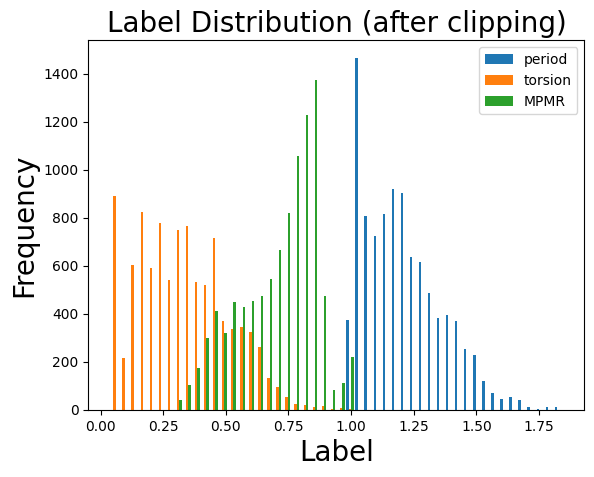

In [ ]:
# Label distribution

# Visualization histtype : {'bar', 'barstacked', 'step', 'stepfilled'}, default: 'bar'
    #The type of histogram to draw.
plt.hist(y, bins=50, density=False, cumulative=False, bottom=None, histtype='bar', align='mid', orientation='vertical', rwidth=None, log=False, color=None, label=['period', 'torsion','MPMR'], stacked=False)
plt.xlabel('Label', fontsize=20)
plt.title('Label Distribution (after clipping)', fontsize=20)
plt.legend(['period', 'torsion','MPMR'])
plt.ylabel('Frequency', fontsize=20)
plt.show()

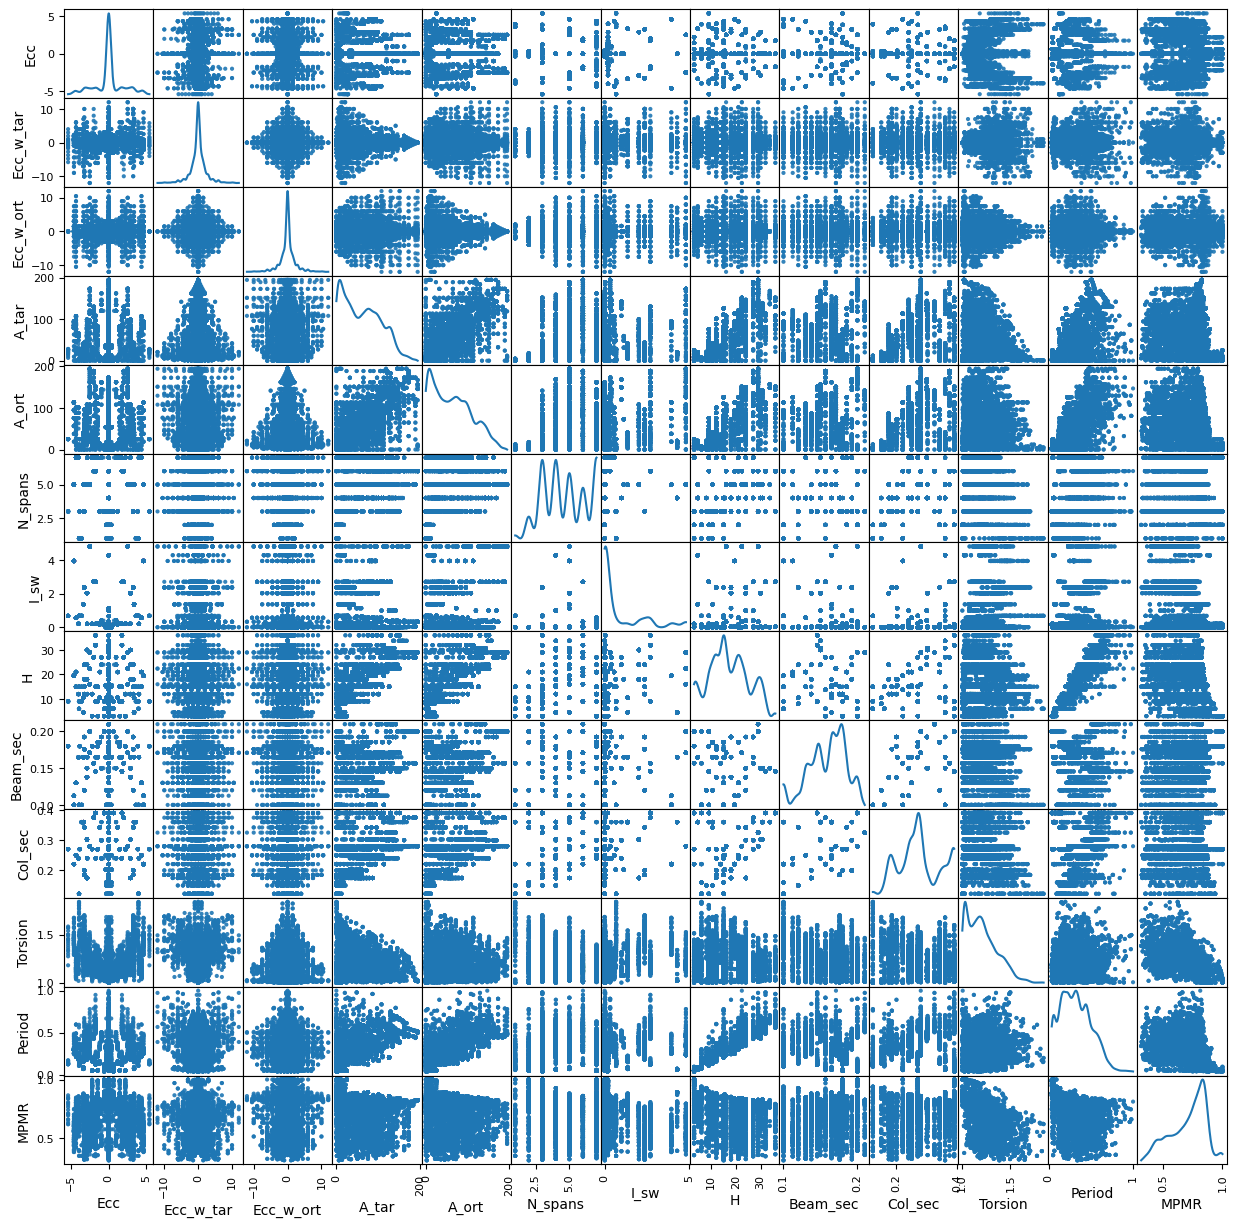

In [ ]:
#scatter matrix plot for features and labels
pd.plotting.scatter_matrix(df, alpha=0.9, figsize=(15, 15), diagonal = 'kde', marker='.', density_kwds=None, hist_kwds=None, range_padding=0.1);

In [ ]:
#calculating number of unique values for certain feature
my_array=np.array(df2['SD1'])
unique_values = np.unique(my_array)
print(unique_values.size)
print(unique_values)


19
[0.1416 0.18   0.214  0.2655 0.29   0.33   0.36   0.388  0.4    0.415
 0.4328 0.46   0.5    0.543  0.6    0.645  0.693  0.728  0.769 ]


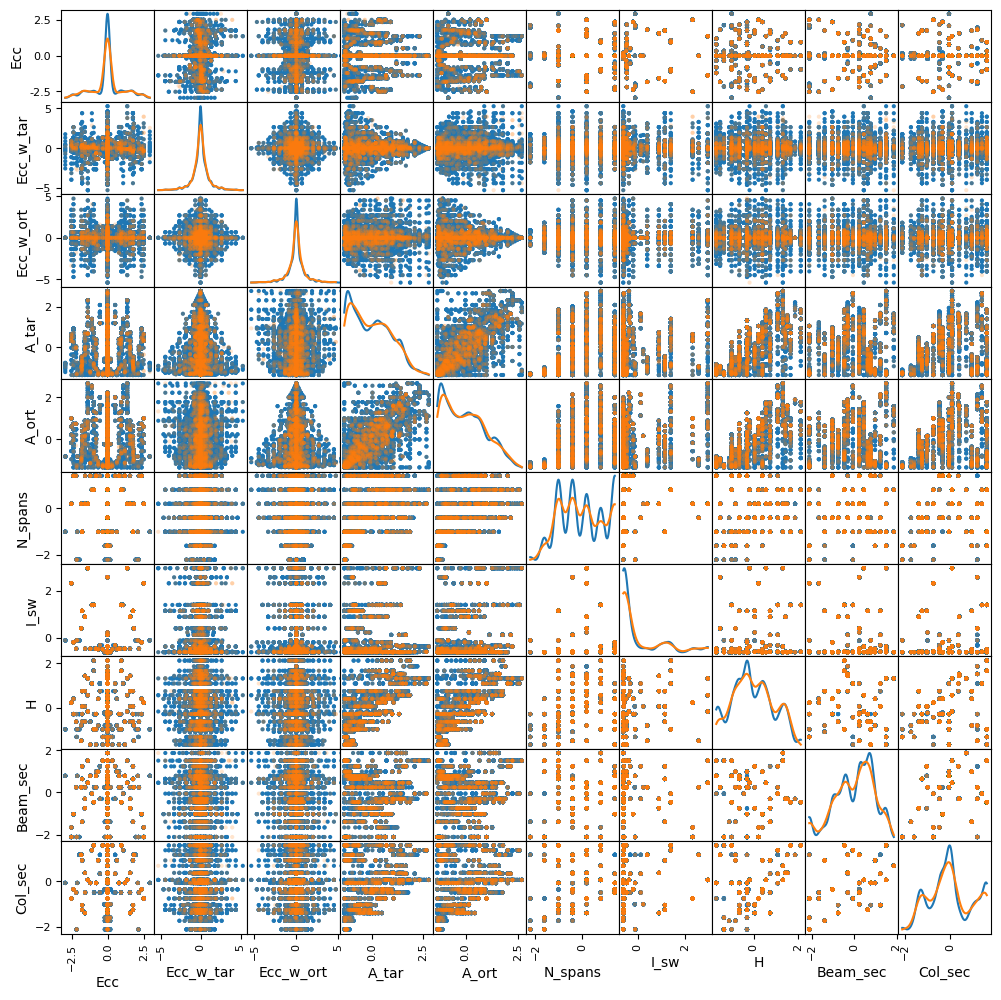

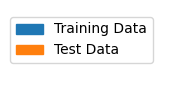

In [ ]:
#scatter plots of the training and test sets after scaling to show the distribution
feature_names2 = ['Ecc','Ecc_w_tar', 'Ecc_w_ort', 'A_tar', 'A_ort',
                 'N_spans', 'I_sw', 'H','Beam_sec','Col_sec']
X_train_scaled2 = pd.DataFrame(X_train_scaled)
X_train_scaled2.columns = feature_names2
X_test_scaled2 = pd.DataFrame(X_test_scaled)
X_test_scaled2.columns = feature_names2
X_scaled2 = pd.DataFrame(X_scaled)
X_scaled2.columns = feature_names2
fig, ax = plt.subplots(10, 10, figsize=(12, 12))
pd.plotting.scatter_matrix(X_train_scaled2, alpha=1, figsize=(15, 15),diagonal = 'kde', ax=ax, marker='.', density_kwds=None, hist_kwds=None, range_padding=0.1, label="training");
pd.plotting.scatter_matrix(X_test_scaled2, alpha=0.2, figsize=(15, 15),diagonal = 'kde', ax=ax, marker='.', density_kwds=None, hist_kwds=None, range_padding=0.1, label="training");
pd.DataFrame({'Training Data':0, 'Test Data':0}, index=['N']).plot(kind='area', legend = 'true',figsize=(1, 1), alpha=1).axis('off');


## *II. ML algorithm implementation*


###1. Random Forest ALgorithm

Average Mean Squared Error: 0.0016703648543156687
Average R-squared: 0.93069419819875


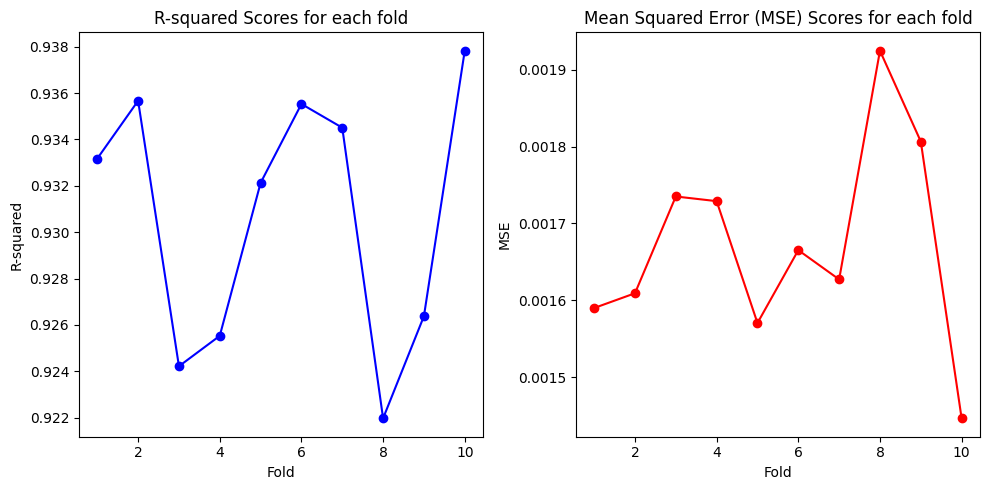

[0.933176150449183, 0.9356698190326953, 0.924218998875452, 0.9255312730469477, 0.9321269934221186, 0.9355314525803404, 0.9345081260872306, 0.9219724778922861, 0.926378149351894, 0.937828541249352]


In [ ]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor

model_RF = RandomForestRegressor(n_estimators = 100, max_depth=18, min_samples_leaf=1, min_samples_split=2, random_state=12)
mse_scores = []  # To store mean squared error scores for each fold
r2_scores1 = []
r2_scores_tor1 = []
r2_scores_per1 = []
r2_scores_mpmr1 = []
k = 10 # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=32)
for train_index, val_index in kf.split(X_train_scaled):
    X_train0, X_val0 = X_train_scaled[train_index], X_train_scaled[val_index]
    y_train0, y_val0 = np.array(y_train)[train_index], np.array(y_train)[val_index]

    # Train and evaluate your model on the current fold
    model_RF.fit(X_train0, y_train0)
    y_pred1 = model_RF.predict(X_val0)

    mse = mean_squared_error(y_val0, y_pred1)  # Calculate mean squared error
    mse_scores.append(mse)

    r2 = r2_score(y_val0, y_pred1)
    r2_scores1.append(r2)
    r2_tor1 = r2_score(y_val0.T[0], y_pred1.T[0])
    r2_scores_tor1.append(r2_tor1)
    r2_per1 = r2_score(y_val0.T[1], y_pred1.T[1])
    r2_scores_per1.append(r2_per1)
    r2_mpmr1 = r2_score(y_val0.T[2], y_pred1.T[2])
    r2_scores_mpmr1.append(r2_mpmr1)
average_mse = np.mean(mse_scores)
average_r2 = np.mean(r2_scores1)
print("Average Mean Squared Error:", average_mse)
print("Average R-squared:", average_r2)

# Plot R-squared and MSE scores for each fold of validation datset with respect to the entire dataset
fold_numbers = np.arange(1, k+1)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(fold_numbers, r2_scores1, marker='o', linestyle='-', color='b')
plt.xlabel('Fold')
plt.ylabel('R-squared')
plt.title('R-squared Scores for each fold')

plt.subplot(1, 2, 2)
plt.plot(fold_numbers, mse_scores, marker='o', linestyle='-', color='r')
plt.xlabel('Fold')
plt.ylabel('MSE')
plt.title('Mean Squared Error (MSE) Scores for each fold')

plt.tight_layout()
plt.show()
print(r2_scores1)

[0.943020900107507, 0.9525917581097938, 0.9510369885411958, 0.9429409621524649, 0.9453605651260116, 0.9586456831761706, 0.9477194158655186, 0.9338056776562139, 0.9483946386597986, 0.9607141071522749]
[0.9912962960580673, 0.9899782705084106, 0.9850336006666556, 0.9904344797030997, 0.9890539216777374, 0.9794736117386272, 0.9886505810844226, 0.9883908929189954, 0.9894218115566081, 0.9915487027274624]
[0.8652112551819747, 0.8644394284798815, 0.8365864074185044, 0.8432183772852787, 0.861966493462607, 0.8684750628262234, 0.8671543813117505, 0.8437208631016488, 0.8413179978392753, 0.8612228138683189]


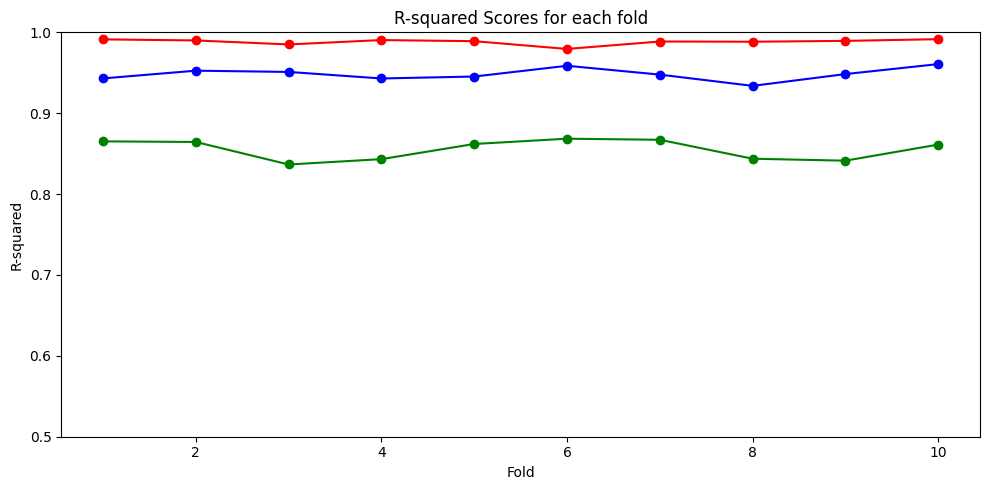

In [ ]:
#visualization of the R2 values for each fold of the validation dataset with respect to torsional irregularity, period and MPMR individualy
print(r2_scores_tor1)
print(r2_scores_per1)
print(r2_scores_mpmr1)
fold_numbers = np.arange(1, k+1)
plt.figure(figsize=(10, 5))
plt.plot(fold_numbers, r2_scores_tor1, marker='o', linestyle='-', color='b')
plt.plot(fold_numbers, r2_scores_per1, marker='o', linestyle='-', color='r')
plt.plot(fold_numbers, r2_scores_mpmr1, marker='o', linestyle='-', color='g')
plt.ylim(0.5, 1)
plt.xlabel('Fold')
plt.ylabel('R-squared')
plt.title('R-squared Scores for each fold')
plt.tight_layout()
plt.show()

In [ ]:
#R2 values for test, train and all model sets, note that these results are for the overall sets without distinguishing between certain label
y_pred_rf1 = model_RF.predict(X_test_scaled)
y_pred_rf2 = model_RF.predict(X_train_scaled)
y_pred_rf3 = model_RF.predict(X_scaled)

r22 = r2_score(y_test, y_pred_rf1)
r23 = r2_score(np.array(y_train), y_pred_rf2)
r24 = r2_score(y, y_pred_rf3)

print(r22)
print(r23)
print(r24)

0.9310246005124562
0.9842079361480592
0.975999816966819


In [ ]:
#define a custom function for scatter plot
def plot_diff(y_true, y_pred,r2, title=''):
    plt.figure(figsize=(5, 5))
    plt.scatter(y_true, y_pred, label=r2, alpha=1,s=25,facecolors='none', edgecolor=(70/255, 130/255, 180/255))
    leg=[matplotlib.lines.Line2D([0],[0], markersize=20)]
    plt.title(title, fontsize=20)
    plt.xlabel('True Values')
    xlabel = plt.gca().xaxis.get_label()
    xlabel.set_size(18)
    plt.xticks(fontsize=14)
    plt.ylabel('Predictions')
    ylabel = plt.gca().yaxis.get_label()
    ylabel.set_size(18)
    plt.yticks(fontsize=14)
    plt.axis('equal')
    plt.axis('square')
    plt.legend(fontsize=14)
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-2, 2], [-2, 2], c=(80/255, 150/255, 200/255, 1))
    plt.show()
#define cutomer MAPE loss function
def mape(y_test, pred):
    y_test, pred = np.array(y_test), np.array(pred)
    mape = np.mean(np.abs((y_test - pred) / y_test))
    return mape

R2 value for torsion of test set 0.942
R2 value for torsion of training set 0.988
R2 value for torsion of all model set 0.981


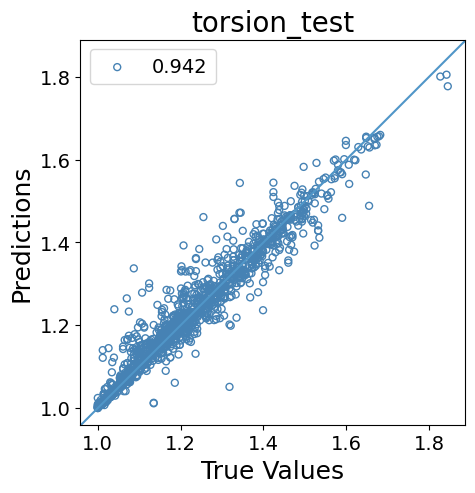

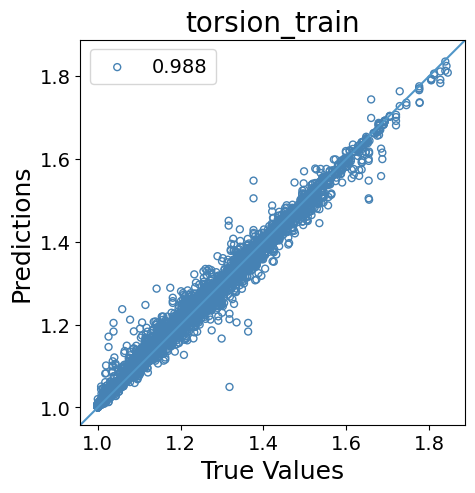

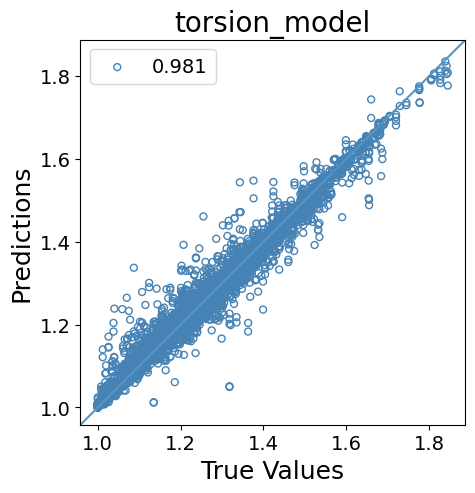

0.991
0.998
0.997


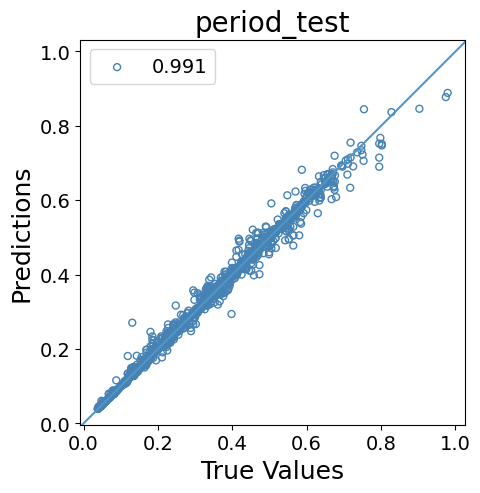

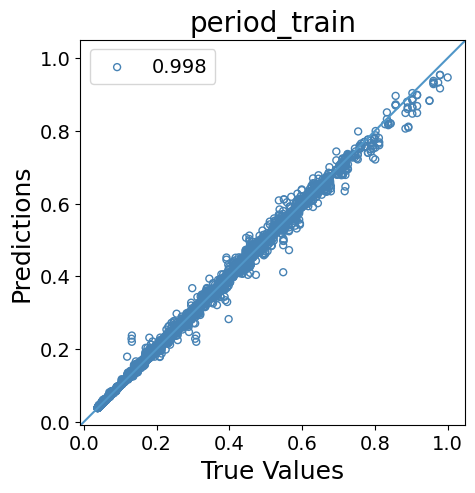

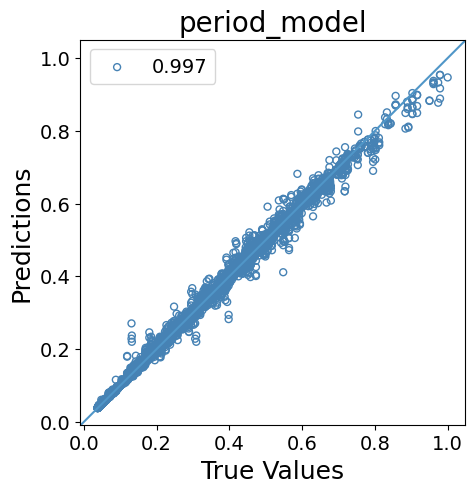

0.86
0.967
0.95


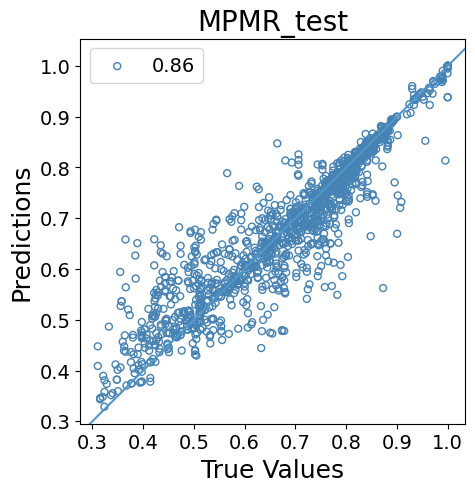

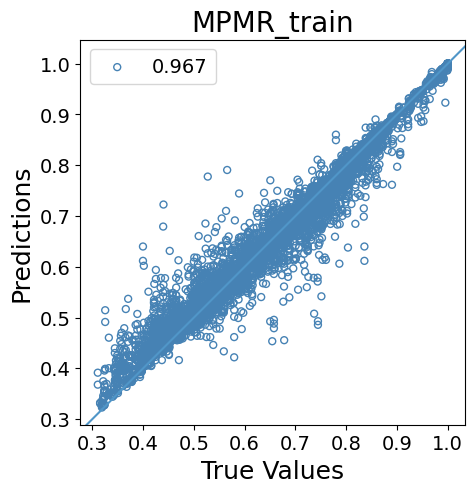

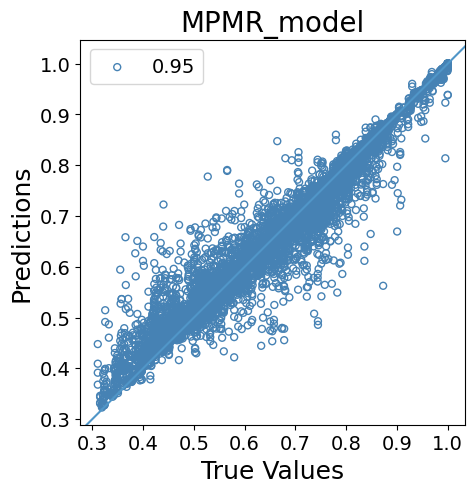

In [ ]:
#plotting predicted vs true values of Torsion results for RF model with line fit
import matplotlib.lines
r2_tor_test = str(round(r2_score(np.array(y_test).T[0], np.array(y_pred_rf1).T[0]), 3))
r2_tor_train = str(round(r2_score(np.array(y_train).T[0], np.array(y_pred_rf2).T[0]),3))
r2_tor_model = str(round(r2_score(np.array(y).T[0], np.array(y_pred_rf3).T[0]),3))
print("R2 value for torsion of test set" ,r2_tor_test)
print("R2 value for torsion of training set" ,r2_tor_train)
print("R2 value for torsion of all model set" ,r2_tor_model)
plot_diff(np.array(y_test).T[0], np.array(y_pred_rf1).T[0], r2_tor_test, title='torsion_test')
plot_diff(np.array(y_train).T[0], np.array(y_pred_rf2).T[0], r2_tor_train, title='torsion_train')
plot_diff(np.array(y).T[0], np.array(y_pred_rf3).T[0], r2_tor_model, title='torsion_model')

#plotting predicted vs true values of period results for RF model with line fit
r2_per_test = str(round(r2_score(np.array(y_test).T[1], np.array(y_pred_rf1).T[1]), 3))
r2_per_train = str(round(r2_score(np.array(y_train).T[1], np.array(y_pred_rf2).T[1]),3))
r2_per_model = str(round(r2_score(np.array(y).T[1], np.array(y_pred_rf3).T[1]),3))
print(r2_per_test)
print(r2_per_train)
print(r2_per_model)
plot_diff(np.array(y_test).T[1], np.array(y_pred_rf1).T[1], r2_per_test, title='period_test')
plot_diff(np.array(y_train).T[1], np.array(y_pred_rf2).T[1], r2_per_train, title='period_train')
plot_diff(np.array(y).T[1], np.array(y_pred_rf3).T[1], r2_per_model, title='period_model')

#plotting predicted vs true values of MPMR for RF model with line fit
r2_mpmr_test = str(round(r2_score(np.array(y_test).T[2], np.array(y_pred_rf1).T[2]), 3))
r2_mpmr_train = str(round(r2_score(np.array(y_train).T[2], np.array(y_pred_rf2).T[2]),3))
r2_mpmr_model = str(round(r2_score(np.array(y).T[2], np.array(y_pred_rf3).T[2]),3))
print(r2_mpmr_test)
print(r2_mpmr_train)
print(r2_mpmr_model)
plot_diff(np.array(y_test).T[2], np.array(y_pred_rf1).T[2], r2_mpmr_test, title='MPMR_test')
plot_diff(np.array(y_train).T[2], np.array(y_pred_rf2).T[2], r2_mpmr_train, title='MPMR_train')
plot_diff(np.array(y).T[2], np.array(y_pred_rf3).T[2], r2_mpmr_model, title='MPMR_model')

In [ ]:
#calculation of evaluation metrics MSE, RMSE, and MAPE, the first index for test, the second for training and the third for all model set
mse1 = mean_squared_error(np.array(y_test).T[0], np.array(y_pred_rf1).T[0])
mse2 = mean_squared_error(np.array(y_train).T[0], np.array(y_pred_rf2).T[0])
mse3 = mean_squared_error(np.array(y).T[0], np.array(y_pred_rf3).T[0])
rmse1 = np.sqrt(mse1)
rmse2 = np.sqrt(mse2)
rmse3 = np.sqrt(mse3)
mape1 = mape(np.array(y_test).T[0], np.array(y_pred_rf1).T[0])
mape2 = mape(np.array(y_train).T[0], np.array(y_pred_rf2).T[0])
mape3 = mape(np.array(y).T[0], np.array(y_pred_rf3).T[0])

mse11 = mean_squared_error(np.array(y_test).T[1], np.array(y_pred_rf1).T[1])
mse22 = mean_squared_error(np.array(y_train).T[1], np.array(y_pred_rf2).T[1])
mse33 = mean_squared_error(np.array(y).T[1], np.array(y_pred_rf3).T[1])
rmse11 = np.sqrt(mse11)
rmse22 = np.sqrt(mse22)
rmse33 = np.sqrt(mse33)
mape11 = mape(np.array(y_test).T[1], np.array(y_pred_rf1).T[1])
mape22 = mape(np.array(y_train).T[1], np.array(y_pred_rf2).T[1])
mape33 = mape(np.array(y).T[1], np.array(y_pred_rf3).T[1])


mse111 = mean_squared_error(np.array(y_test).T[2], np.array(y_pred_rf1).T[2])
mse222 = mean_squared_error(np.array(y_train).T[2], np.array(y_pred_rf2).T[2])
mse333 = mean_squared_error(np.array(y).T[2], np.array(y_pred_rf3).T[2])
rmse111 = np.sqrt(mse111)
rmse222 = np.sqrt(mse222)
rmse333 = np.sqrt(mse333)
mape111 = mape(np.array(y_test).T[2], np.array(y_pred_rf1).T[2])
mape222 = mape(np.array(y_train).T[2], np.array(y_pred_rf2).T[2])
mape333 = mape(np.array(y).T[2], np.array(y_pred_rf3).T[2])
rmse_torsion=[rmse1,rmse2,rmse3]
rmse_period=[rmse11,rmse22,rmse33]
rmse_mpmr=[rmse111,rmse222,rmse333]

mape_torsion=[mape1,mape2,mape3]
mape_period=[mape11,mape22,mape33]
mape_mpmr=[mape111,mape222,mape333]

mse_torsion=[mse1,mse2,mse3]
mse_period=[mse11,mse22,mse33]
mse_mpmr=[mse111,mse222,mse333]
print("mse torsion of RF")
print(mse_torsion)
print("mse period of RF")
print(mse_period)
print("mse mpmr of RF")
print(mse_mpmr)
##########
print("rmse torsion of RF")
print(rmse_torsion)
print("rmse period of RF")
print(rmse_period)
print("rmse mpmr of RF")
print(rmse_mpmr)
##########
print("mape torsion of RF")
print(mape_torsion)
print("mape period of RF")
print(mape_period)
print("mape mpmr of RF")
print(mape_mpmr)


mse torsion of RF
[0.0014287553525229508, 0.00028306238333417847, 0.0004549811370158013]
mse period of RF
[0.0002763579082760656, 7.389431201542319e-05, 0.00010427530419317462]
mse mpmr of RF
[0.003442600539796836, 0.0007832497031335579, 0.001182302759874453]
rmse torsion of RF
[0.03779888030779418, 0.0168244578912421, 0.021330286847949357]
rmse period of RF
[0.016624016009257978, 0.008596180082770672, 0.010211528004817625]
rmse mpmr of RF
[0.05867367842394779, 0.027986598634588626, 0.0343846297039019]
mape torsion of RF
[0.017658256940557414, 0.007419487232429591, 0.008955881864143929]
mape period of RF
[0.026841466883001572, 0.012097946357475162, 0.014310308431602801]
mape mpmr of RF
[0.06124369427437885, 0.025604322123432853, 0.030952243954990005]


_____________________________________________________________
###2. DNN algorithm

---



Streaming output truncated to the last 5000 lines.
117/117 [==============================] - 0s 2ms/step - loss: 0.0016 - mae: 0.0270
Epoch 5/500
117/117 [==============================] - 0s 2ms/step - loss: 0.0016 - mae: 0.0269
Epoch 6/500
117/117 [==============================] - 0s 2ms/step - loss: 0.0016 - mae: 0.0271
Epoch 7/500
117/117 [==============================] - 0s 2ms/step - loss: 0.0016 - mae: 0.0270
Epoch 8/500
117/117 [==============================] - 0s 2ms/step - loss: 0.0016 - mae: 0.0271
Epoch 9/500
117/117 [==============================] - 0s 2ms/step - loss: 0.0016 - mae: 0.0269
Epoch 10/500
117/117 [==============================] - 0s 2ms/step - loss: 0.0016 - mae: 0.0269
Epoch 11/500
117/117 [==============================] - 0s 2ms/step - loss: 0.0016 - mae: 0.0271
Epoch 12/500
117/117 [==============================] - 0s 3ms/step - loss: 0.0016 - mae: 0.0270
Epoch 13/500
117/117 [==============================] - 0s 2ms/step - loss: 0.0016 - mae: 0.02

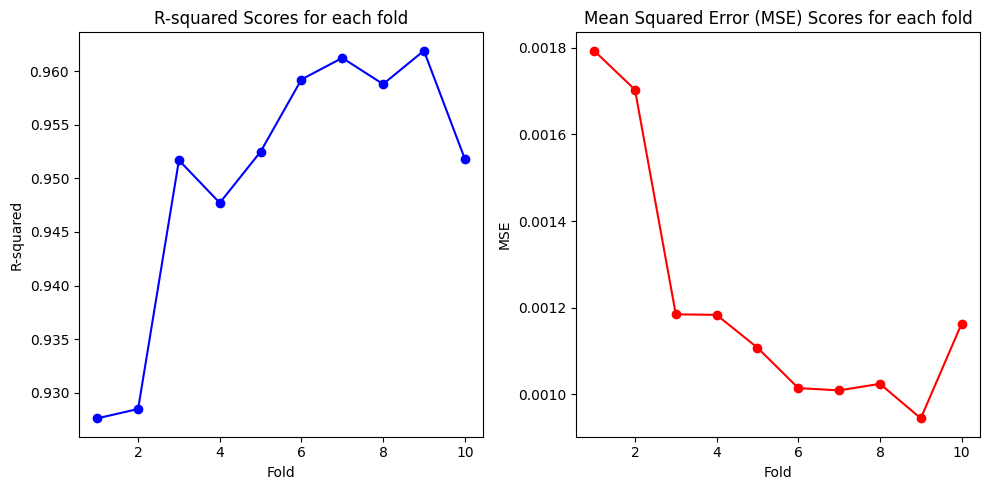

[0.9275970168517821, 0.9284701587979055, 0.9516964588227511, 0.9477185333701271, 0.9524968366545528, 0.959237586721505, 0.9612544199569816, 0.9588074833641818, 0.9619256679072228, 0.9518445702244693]


In [ ]:
k = 10  # Number of folds
kf = KFold(n_splits=k, shuffle=True)
mse_scores = []
r2_scores2 = []  # To store R-squared scores for each fold
r2_scores_tor2= []
r2_scores_per2= []
r2_scores_mpmr2= []
# define the model Keras sequential
#Experiment with deeper and wider networks
from keras import regularizers
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import KFold

model = Sequential()
model.add(Dense(50, input_dim=10, activation='tanh'))
model.add(Dropout(0.02))  # Dropout rate of 0.1
model.add(Dense(50, activation='tanh'))
model.add(Dropout(0.02))  # Dropout rate of 0.1
model.add(Dense(20, activation='sigmoid'))
model.add(Dropout(0.02))  # Dropout rate of 0.1
model.add(Dense(20, activation='sigmoid'))
model.add(Dropout(0.02))  # Dropout rate of 0.1
model.add(Dense(20, activation='sigmoid'))
model.add(Dropout(0.02))  # Dropout rate of 0.1

#Output layer
model.add(Dense(3, activation='linear'))
optimizer1 ='adam'
optimizer2 ='SGD'
optimizer3 ='adamax'
optimizer4 ='Adadelta'
optimizer5 = 'Adagrad'
optimizer6 ='Ftrl'
optimizer7 ='Nadam'
optimizer8 ='RMSprop'
loss1 = 'mean_squared_error'
loss2 = 'MeanAbsoluteError'
loss3 = 'MeanAbsolutePercentageError'
loss4 = 'MeanSquaredLogarithmicError'
loss4 = 'binary_crossentropy'
loss6 = tf.keras.losses.Poisson()
metrics1 = 'mae'
metrics2 = 'mse'
metrics3 = 'rmse'
metrics4 = 'accuracy'

model.compile(loss=loss1, optimizer=optimizer1, metrics=[metrics1])
model.summary()
for train_index, test_index in kf.split(X_train_scaled):
    X_train2, X_val2 = X_train_scaled[train_index], X_train_scaled[test_index]
    y_train2, y_val2 = np.array(y_train)[train_index], np.array(y_train)[test_index]
    history = model.fit(X_train2, y_train2, epochs=500,batch_size=64)

    y_pred2 = model.predict(X_val2)  # Make predictions on the test set
    r2 = r2_score(y_val2, y_pred2)  # Calculate R-squared
    r2_scores2.append(r2)
    r2_tor2 = r2_score(y_val2.T[0], y_pred2.T[0])
    r2_scores_tor2.append(r2_tor2)
    r2_per2 = r2_score(y_val2.T[1], y_pred2.T[1])
    r2_scores_per2.append(r2_per2)
    r2_mpmr2 = r2_score(y_val2.T[2], y_pred2.T[2])
    r2_scores_mpmr2.append(r2_mpmr2)
    mse = mean_squared_error(y_val2, y_pred2)  # Calculate mean squared error
    mse_scores.append(mse)

average_mse = np.mean(mse_scores)
print("Average Mean Squared Error:", average_mse)
average_r2 = np.mean(r2_scores2)
print("Average R-squared:", average_r2)
# Plot R-squared and MSE scores
fold_numbers = np.arange(1, k+1)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(fold_numbers, r2_scores2, marker='o', linestyle='-', color='b')
plt.xlabel('Fold')
plt.ylabel('R-squared')
plt.title('R-squared Scores for each fold')

plt.subplot(1, 2, 2)
plt.plot(fold_numbers, mse_scores, marker='o', linestyle='-', color='r')
plt.xlabel('Fold')
plt.ylabel('MSE')
plt.title('Mean Squared Error (MSE) Scores for each fold')

plt.tight_layout()
plt.show()
print(r2_scores2)

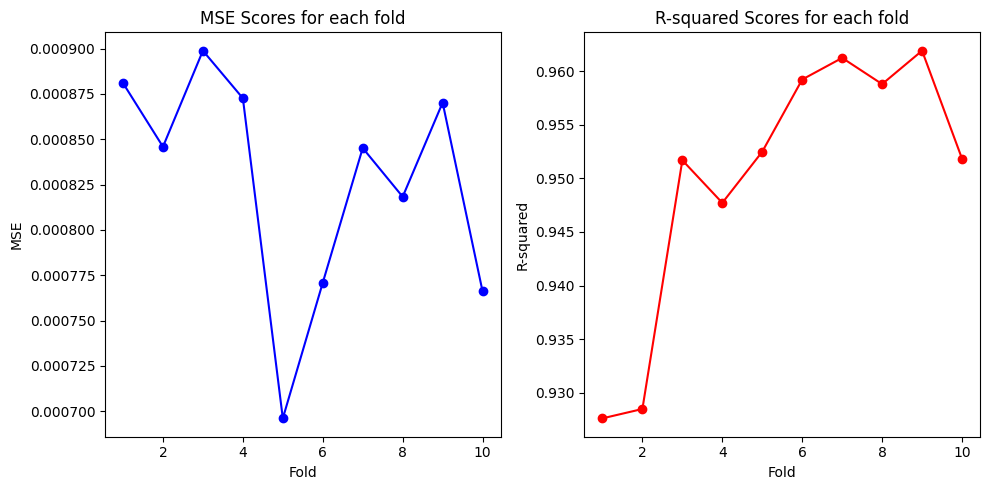

In [ ]:
fold_numbers = np.arange(1, k+1)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(fold_numbers, mse_scores, marker='o', linestyle='-', color='b')
plt.xlabel('Fold')
plt.ylabel('MSE')
plt.title('MSE Scores for each fold')

plt.subplot(1, 2, 2)
plt.plot(fold_numbers, r2_scores2, marker='o', linestyle='-', color='r')
plt.xlabel('Fold')
plt.ylabel('R-squared')
plt.title('R-squared Scores for each fold')

plt.tight_layout()
plt.show()

304/304 [==============================] - 1s 2ms/step


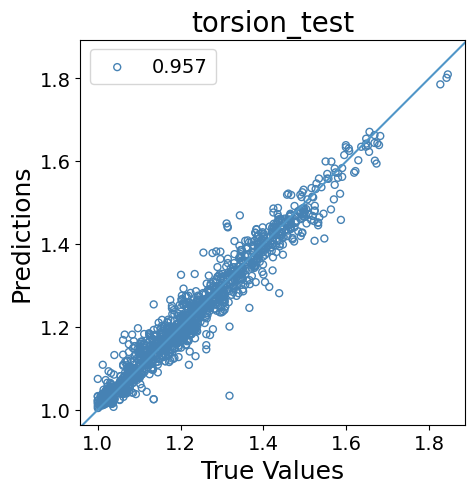

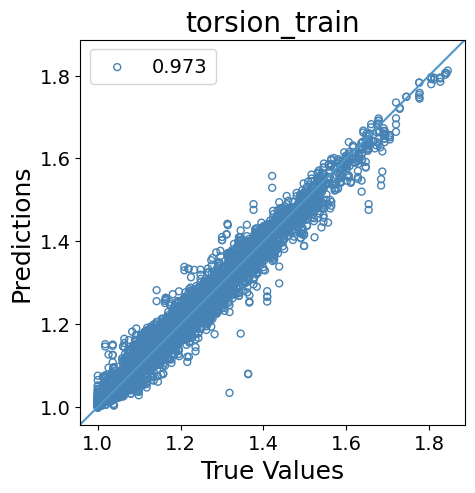

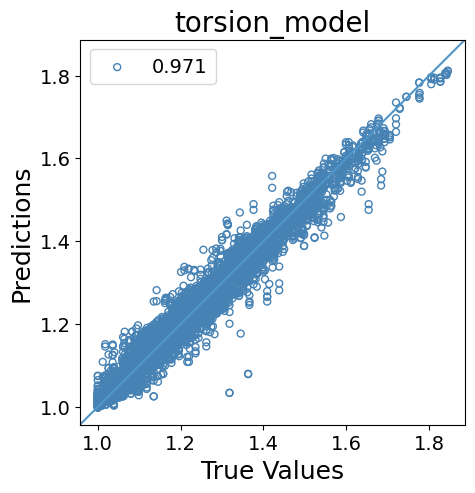

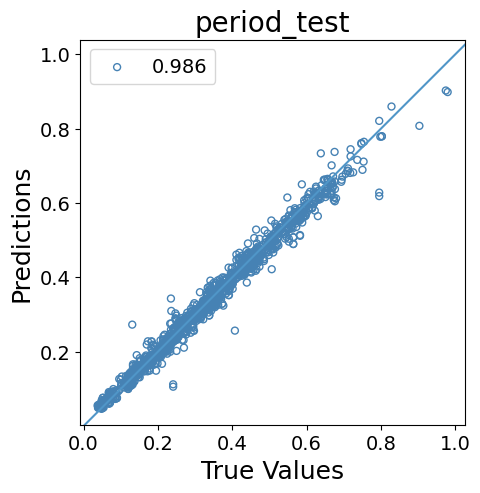

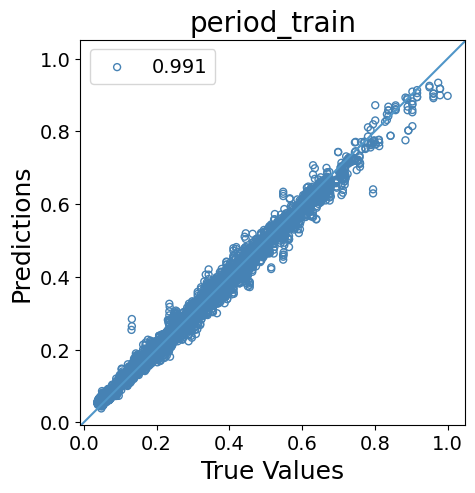

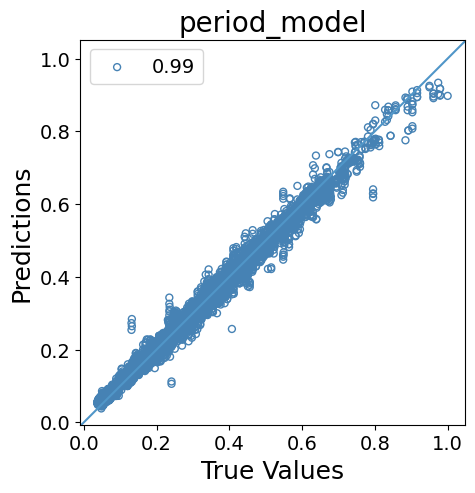

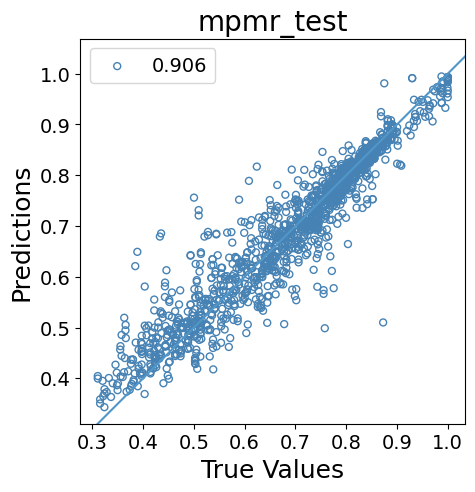

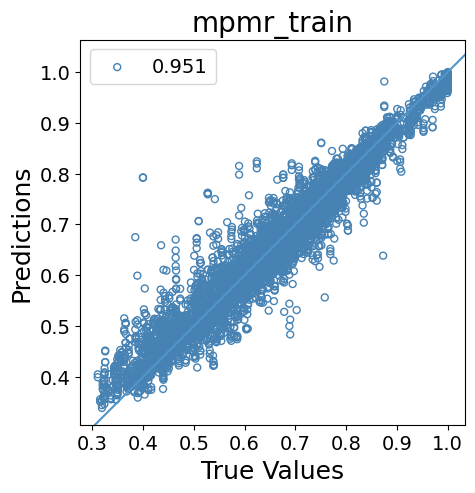

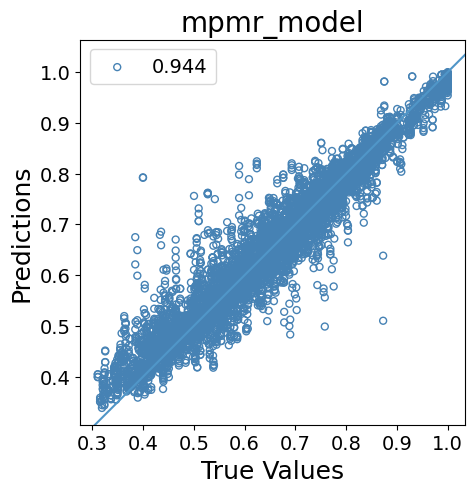

In [ ]:
y_pred2 = model.predict(X_test_scaled)
y_pred3 = model.predict(X_train_scaled)
y_pred4 = model.predict(X_scaled)

mse2 = mean_squared_error(y_test, y_pred2)
mse3 = mean_squared_error(np.array(y_train), y_pred3)
mse4 = mean_squared_error(y, y_pred4)

r22 = r2_score(y_test, y_pred2)
r23 = r2_score(np.array(y_train), y_pred3)
r24 = r2_score(y, y_pred4)

r2_tor_test = str(round(r2_score(np.array(y_test).T[0], np.array(y_pred2).T[0]), 3))
r2_tor_train = str(round(r2_score(np.array(y_train).T[0], np.array(y_pred3).T[0]),3))
r2_tor_model = str(round(r2_score(np.array(y).T[0], np.array(y_pred4).T[0]),3))

plot_diff(np.array(y_test).T[0], np.array(y_pred2).T[0], r2_tor_test, title='torsion_test')
plot_diff(np.array(y_train).T[0], np.array(y_pred3).T[0], r2_tor_train, title='torsion_train')
plot_diff(np.array(y).T[0], np.array(y_pred4).T[0], r2_tor_model, title='torsion_model')
#plotting predicted vs true values of nn model with line fit
import matplotlib.lines
r2_per_test = str(round(r2_score(np.array(y_test).T[1], np.array(y_pred2).T[1]), 3))
r2_per_train = str(round(r2_score(np.array(y_train).T[1], np.array(y_pred3).T[1]),3))
r2_per_model = str(round(r2_score(np.array(y).T[1], np.array(y_pred4).T[1]),3))

plot_diff(np.array(y_test).T[1], np.array(y_pred2).T[1], r2_per_test, title='period_test')
plot_diff(np.array(y_train).T[1], np.array(y_pred3).T[1], r2_per_train, title='period_train')
plot_diff(np.array(y).T[1], np.array(y_pred4).T[1], r2_per_model, title='period_model')
#plotting predicted vs true values of nn model with line fit
import matplotlib.lines
r2_mpmr_test = str(round(r2_score(np.array(y_test).T[2], np.array(y_pred2).T[2]), 3))
r2_mpmr_train = str(round(r2_score(np.array(y_train).T[2], np.array(y_pred3).T[2]),3))
r2_mpmr_model = str(round(r2_score(np.array(y).T[2], np.array(y_pred4).T[2]),3))

plot_diff(np.array(y_test).T[2], np.array(y_pred2).T[2], r2_mpmr_test, title='mpmr_test')
plot_diff(np.array(y_train).T[2], np.array(y_pred3).T[2], r2_mpmr_train, title='mpmr_train')
plot_diff(np.array(y).T[2], np.array(y_pred4).T[2], r2_mpmr_model, title='mpmr_model')

In [ ]:
mse_nn_1 = mean_squared_error(np.array(y_test).T[0], np.array(y_pred2).T[0])
mse_nn_2 = mean_squared_error(np.array(y_train).T[0], np.array(y_pred3).T[0])
mse_nn_3 = mean_squared_error(np.array(y).T[0], np.array(y_pred4).T[0])
mse_nn_11 = mean_squared_error(np.array(y_test).T[1], np.array(y_pred2).T[1])
mse_nn_22 = mean_squared_error(np.array(y_train).T[1], np.array(y_pred3).T[1])
mse_nn_33 = mean_squared_error(np.array(y).T[1], np.array(y_pred4).T[1])
mse_nn_111 = mean_squared_error(np.array(y_test).T[2], np.array(y_pred2).T[2])
mse_nn_222 = mean_squared_error(np.array(y_train).T[2], np.array(y_pred3).T[2])
mse_nn_333 = mean_squared_error(np.array(y).T[2], np.array(y_pred4).T[2])
mse_torsion2=[mse_nn_1,mse_nn_2,mse_nn_3]
mse_period2=[mse_nn_11,mse_nn_22,mse_nn_33]
mse_mpmr2=[mse_nn_111,mse_nn_222,mse_nn_333]
print('mse_nn')
print(mse_torsion2)
print(mse_period2)
print(mse_mpmr2)

rmse1 = np.sqrt(mse_nn_1)
rmse2 = np.sqrt(mse_nn_2)
rmse3 = np.sqrt(mse_nn_3)
rmse11 = np.sqrt(mse_nn_11)
rmse22 = np.sqrt(mse_nn_22)
rmse33 = np.sqrt(mse_nn_33)
rmse111 = np.sqrt(mse_nn_111)
rmse222 = np.sqrt(mse_nn_222)
rmse333 = np.sqrt(mse_nn_333)

rmse_torsion2=[rmse1,rmse2,rmse3]
rmse_period2=[rmse11,rmse22,rmse33]
rmse_mpmr2=[rmse111,rmse222,rmse333]
print('rmse_nn')
print(rmse_torsion2)
print(rmse_period2)
print(rmse_mpmr2)

mape_nn_1 = mape(np.array(y_test).T[0], np.array(y_pred2).T[0])
mape_nn_2 = mape(np.array(y_train).T[0], np.array(y_pred3).T[0])
mape_nn_3 = mape(y_0, np.array(y_pred4).T[0])
mape_nn_11 = mape(np.array(y_test).T[1], np.array(y_pred2).T[1])
mape_nn_22 = mape(np.array(y_train).T[1], np.array(y_pred3).T[1])
mape_nn_33 = mape(y_1, np.array(y_pred4).T[1])
mape_nn_111 = mape(np.array(y_test).T[2], np.array(y_pred2).T[2])
mape_nn_222 = mape(np.array(y_train).T[2], np.array(y_pred3).T[2])
mape_nn_333 = mape(y_2, np.array(y_pred4).T[2])

mape_torsion2=[mape_nn_1,mape_nn_2,mape_nn_3]
mape_period2=[mape_nn_11,mape_nn_22,mape_nn_33]
mape_mpmr2=[mape_nn_111,mape_nn_222,mape_nn_333]
print('mape_nn')

print(mape_torsion2)
print(mape_period2)
print(mape_mpmr2)

mse_nn
[0.0010493394449413293, 0.0006612924291919299, 0.0007195214327039486]
[0.00044539083504606977, 0.00029166752066256505, 0.00031473471796068163]
[0.0023182943508962377, 0.0011516790924929444, 0.0013267373849945544]
rmse_nn
[0.03239350930265706, 0.025715606724165188, 0.026823896672630333]
[0.02110428475561467, 0.017078276279020813, 0.01774076430035306]
[0.04814866925363813, 0.03393639775363532, 0.03642440644670211]
mape_nn
[0.018387759691865055, 0.014841533910465641, 0.015373668454119619]
[0.0552843062961606, 0.05423990511957375, 0.05439662479780742]
[0.05270059897551297, 0.03695230011024298, 0.03931543599445584]




---


###3. DT Algorithm

---



Average Mean Squared Error: 0.002704351896393336
Average R-squared: 0.8879942251144535


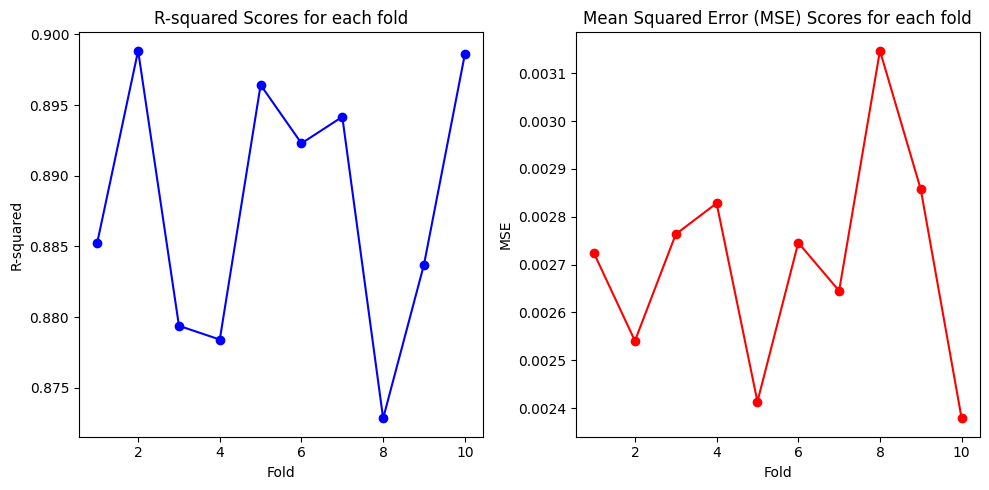

[0.8852784685341932, 0.898841992033435, 0.8793887771660988, 0.8784163752014177, 0.8964221070818844, 0.8922901423054389, 0.8941670168044729, 0.8728454171243221, 0.883716863092749, 0.898575091800522]


In [ ]:
from sklearn.tree import DecisionTreeRegressor
#"friedman_mse", "absolute_error",             "poisson"
tree = DecisionTreeRegressor(criterion='squared_error',max_depth=18, min_samples_leaf=2, min_samples_split=5, random_state=4)
mse_scores = []  # To store mean squared error scores for each fold
r2_scores3 = []
r2_scores_tor3=[]
r2_scores_per3=[]
r2_scores_mpmr3=[]
k = 10 # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=32)
for train_index, val_index in kf.split(X_train_scaled):
    X_train0, X_val0 = X_train_scaled[train_index], X_train_scaled[val_index]
    y_train0, y_val0 = np.array(y_train)[train_index], np.array(y_train)[val_index]

    # Train and evaluate your model on the current fold
    tree.fit(X_train0, y_train0)
    y_pred3 = tree.predict(X_val0)

    mse = mean_squared_error(y_val0, y_pred3)  # Calculate mean squared error
    mse_scores.append(mse)

    r2 = r2_score(y_val0, y_pred3)  # Calculate R-squared
    r2_scores3.append(r2)
    r2_tor3 = r2_score(y_val0.T[0], y_pred3.T[0])
    r2_scores_tor3.append(r2_tor3)
    r2_per3 = r2_score(y_val0.T[1], y_pred3.T[1])
    r2_scores_per3.append(r2_per3)
    r2_mpmr3 = r2_score(y_val0.T[2], y_pred3.T[2])
    r2_scores_mpmr3.append(r2_mpmr3)

average_mse = np.mean(mse_scores)
average_r2 = np.mean(r2_scores3)
print("Average Mean Squared Error:", average_mse)
print("Average R-squared:", average_r2)
# Plot R-squared and MSE scores
fold_numbers = np.arange(1, k+1)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(fold_numbers, r2_scores3, marker='o', linestyle='-', color='b')
plt.xlabel('Fold')
plt.ylabel('R-squared')
plt.title('R-squared Scores for each fold')

plt.subplot(1, 2, 2)
plt.plot(fold_numbers, mse_scores, marker='o', linestyle='-', color='r')
plt.xlabel('Fold')
plt.ylabel('MSE')
plt.title('Mean Squared Error (MSE) Scores for each fold')

plt.tight_layout()
plt.show()
print(r2_scores3)

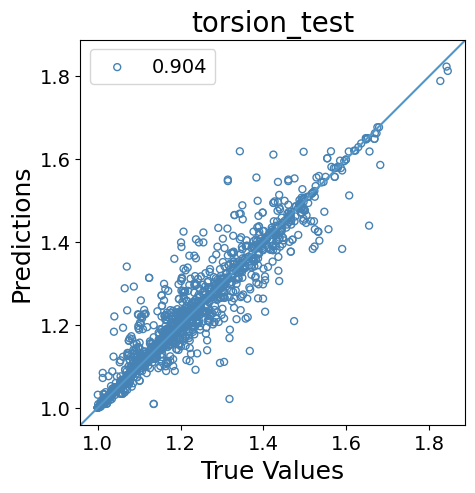

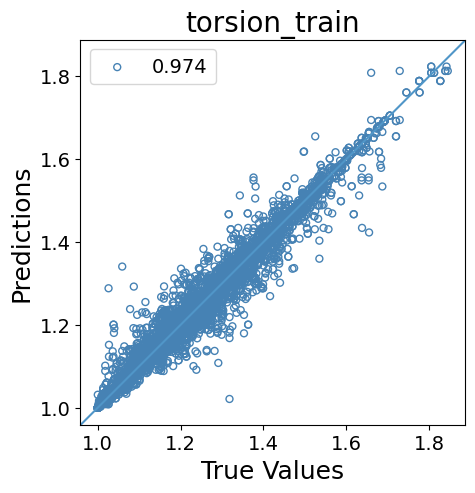

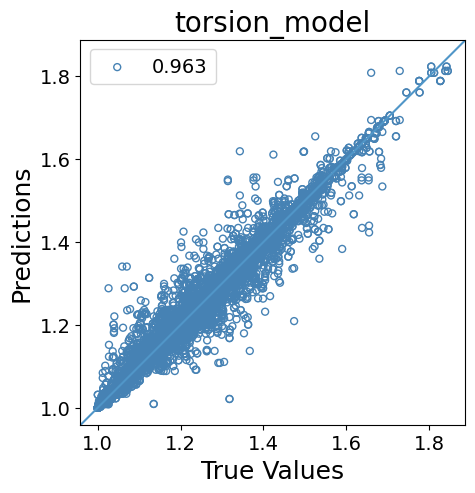

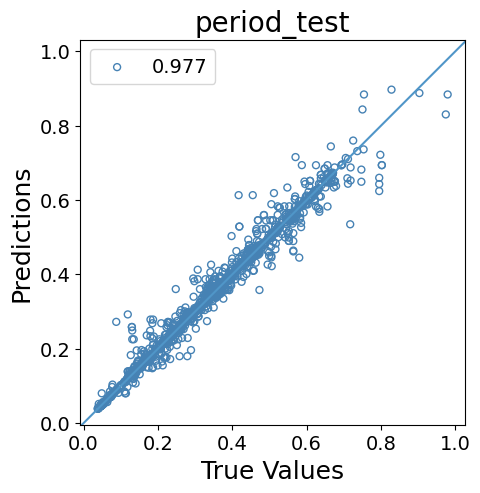

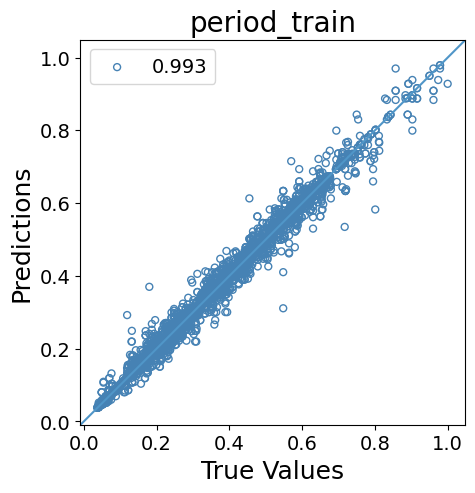

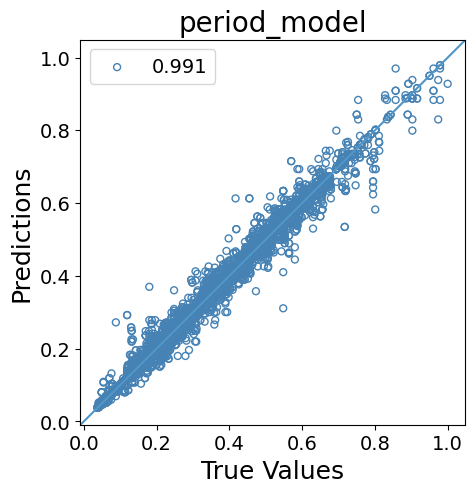

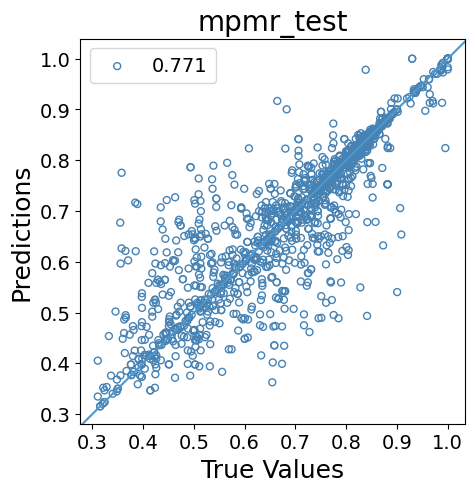

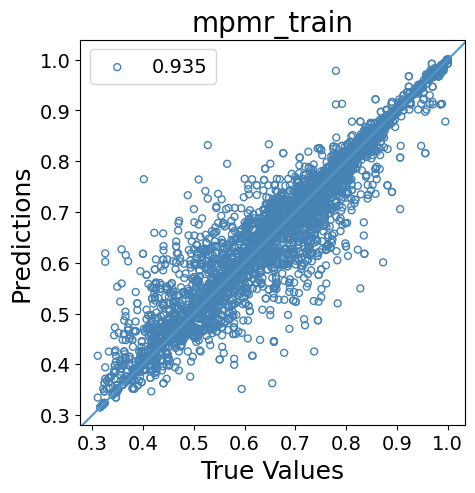

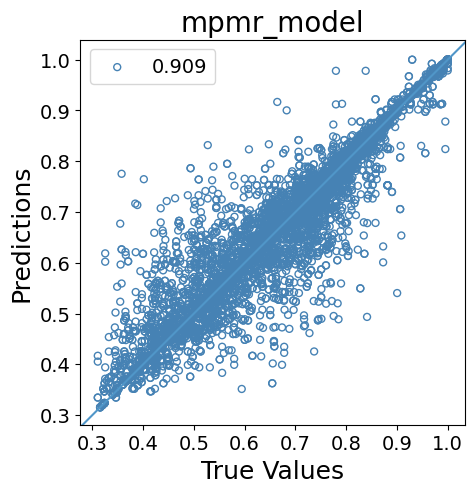

In [ ]:
y_pred2dt = tree.predict(X_test_scaled)
y_pred3dt = tree.predict(X_train_scaled)
y_pred4dt = tree.predict(X_scaled)


r22 = r2_score(y_test, y_pred2dt)
r23 = r2_score(np.array(y_train), y_pred3dt)
r24 = r2_score(y, y_pred4dt)

r2_tor_test = str(round(r2_score(np.array(y_test).T[0], np.array(y_pred2dt).T[0]), 3))
r2_tor_train = str(round(r2_score(np.array(y_train).T[0], np.array(y_pred3dt).T[0]),3))
r2_tor_model = str(round(r2_score(np.array(y).T[0], np.array(y_pred4dt).T[0]),3))

plot_diff(np.array(y_test).T[0], np.array(y_pred2dt).T[0], r2_tor_test, title='torsion_test')
plot_diff(np.array(y_train).T[0], np.array(y_pred3dt).T[0], r2_tor_train, title='torsion_train')
plot_diff(np.array(y).T[0], np.array(y_pred4dt).T[0], r2_tor_model, title='torsion_model')

r2_per_test = str(round(r2_score(np.array(y_test).T[1], np.array(y_pred2dt).T[1]), 3))
r2_per_train = str(round(r2_score(np.array(y_train).T[1], np.array(y_pred3dt).T[1]),3))
r2_per_model = str(round(r2_score(np.array(y).T[1], np.array(y_pred4dt).T[1]),3))

plot_diff(np.array(y_test).T[1], np.array(y_pred2dt).T[1], r2_per_test, title='period_test')
plot_diff(np.array(y_train).T[1], np.array(y_pred3dt).T[1], r2_per_train, title='period_train')
plot_diff(np.array(y).T[1], np.array(y_pred4dt).T[1], r2_per_model, title='period_model')
r2_mpmr_test = str(round(r2_score(np.array(y_test).T[2], np.array(y_pred2dt).T[2]), 3))
r2_mpmr_train = str(round(r2_score(np.array(y_train).T[2], np.array(y_pred3dt).T[2]),3))
r2_mpmr_model = str(round(r2_score(np.array(y).T[2], np.array(y_pred4dt).T[2]),3))

plot_diff(np.array(y_test).T[2], np.array(y_pred2dt).T[2], r2_mpmr_test, title='mpmr_test')
plot_diff(np.array(y_train).T[2], np.array(y_pred3dt).T[2], r2_mpmr_train, title='mpmr_train')
plot_diff(np.array(y).T[2], np.array(y_pred4dt).T[2], r2_mpmr_model, title='mpmr_model')

In [ ]:
mse_dt_1 = mean_squared_error(np.array(y_test).T[0], np.array(y_pred2dt).T[0])
mse_dt_2 = mean_squared_error(np.array(y_train).T[0], np.array(y_pred3dt).T[0])
mse_dt_3 = mean_squared_error(np.array(y).T[0], np.array(y_pred4dt).T[0])
mse_dt_11 = mean_squared_error(np.array(y_test).T[1], np.array(y_pred2dt).T[1])
mse_dt_22 = mean_squared_error(np.array(y_train).T[1], np.array(y_pred3dt).T[1])
mse_dt_33 = mean_squared_error(np.array(y).T[1], np.array(y_pred4dt).T[1])
mse_dt_111 = mean_squared_error(np.array(y_test).T[2], np.array(y_pred2dt).T[2])
mse_dt_222 = mean_squared_error(np.array(y_train).T[2], np.array(y_pred3dt).T[2])
mse_dt_333 = mean_squared_error(np.array(y).T[2], np.array(y_pred4dt).T[2])

rmse_dt_1 = np.sqrt(mse_dt_1)
rmse_dt_2 = np.sqrt(mse_dt_2)
rmse_dt_3 = np.sqrt(mse_dt_3)
rmse_dt_11 = np.sqrt(mse_dt_11)
rmse_dt_22 = np.sqrt(mse_dt_22)
rmse_dt_33 = np.sqrt(mse_dt_33)
rmse_dt_111 = np.sqrt(mse_dt_111)
rmse_dt_222 = np.sqrt(mse_dt_222)
rmse_dt_333 = np.sqrt(mse_dt_333)

mape_dt_1 = mape(np.array(y_test).T[0], np.array(y_pred2dt).T[0])
mape_dt_2 = mape(np.array(y_train).T[0], np.array(y_pred3dt).T[0])
mape_dt_3 = mape(np.array(y).T[0], np.array(y_pred4dt).T[0])
mape_dt_11 = mape(np.array(y_test).T[1], np.array(y_pred2dt).T[1])
mape_dt_22 = mape(np.array(y_train).T[1], np.array(y_pred3dt).T[1])
mape_dt_33 = mape(np.array(y).T[1], np.array(y_pred4dt).T[1])
mape_dt_111 = mape(np.array(y_test).T[2], np.array(y_pred2dt).T[2])
mape_dt_222 = mape(np.array(y_train).T[2], np.array(y_pred3dt).T[2])
mape_dt_333 = mape(np.array(y).T[2], np.array(y_pred4dt).T[2])

mse_torsion3=[mse_dt_1,mse_dt_2,mse_dt_3]
mse_period3=[mse_dt_11,mse_dt_22,mse_dt_33]
mse_mpmr3=[mse_dt_111,mse_dt_222,mse_dt_333]

rmse_torsion3=[rmse_dt_1,rmse_dt_2,rmse_dt_3]
rmse_period3=[rmse_dt_11,rmse_dt_22,rmse_dt_33]
rmse_mpmr3=[rmse_dt_111,rmse_dt_222,rmse_dt_333]

mape_torsion3=[mape_dt_1,mape_dt_2,mape_dt_3]
mape_period3=[mape_dt_11,mape_dt_22,mape_dt_33]
mape_mpmr3=[mape_dt_111,mape_dt_222,mape_dt_333]

print("mse torsion of dt")
print(mse_torsion3)
print("mse period of dt")
print(mse_period3)
print("mse mpmr of dt")
print(mse_mpmr3)
##########
print("rmse torsion of dt")
print(rmse_torsion3)
print("rmse period of dt")
print(rmse_period3)
print("rmse mpmr of dt")
print(rmse_mpmr3)
##########
print("mape torsion of dt")
print(mape_torsion3)
print("mape period of dt")
print(mape_period3)
print("mape mpmr of dt")
print(mape_mpmr3)

mse torsion of dt
[0.0023451610299583567, 0.0006453787888340677, 0.0009004422764202385]
mse period of dt
[0.0007258833383422155, 0.00022630486006955231, 0.00030126989141788266]
mse mpmr of dt
[0.0056441710670281035, 0.0015261186990496052, 0.0021440594997161307]
rmse torsion of dt
[0.04842686268961016, 0.025404306501734458, 0.030007370368298494]
rmse period of dt
[0.02694222222353263, 0.015043432456376182, 0.017357127971467014]
rmse mpmr of dt
[0.0751276984009766, 0.03906556922725695, 0.046303990105779555]
mape torsion of dt
[0.021736436281736667, 0.010191290595225347, 0.011923715521340745]
mape period of dt
[0.041775287220448105, 0.021053043316480596, 0.024162552095241117]
mape mpmr of dt
[0.07222142070684398, 0.031450665204863934, 0.0375685848055416]




---



---



###**4. AdaBoost model**



---


---





In [ ]:
#decision Tree Regression with AdaBoost
from sklearn.ensemble import AdaBoostRegressor

AdaBoost_reg1 = AdaBoostRegressor(
    DecisionTreeRegressor(max_depth=10), learning_rate=0.1, n_estimators=150, random_state=10)

multioutput_model_ada = MultiOutputRegressor(AdaBoost_reg1)
mse_scores4 = []  # To store mean squared error scores for each fold
r2_scores4 = []
r2_scores_tor4 = []
r2_scores_per4 = []
r2_scores_mpmr4 = []
k = 10 # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=32)
for train_index, val_index in kf.split(X_train_scaled):
    X_train0, X_val0 = X_train_scaled[train_index], X_train_scaled[val_index]
    y_train0, y_val0 = np.array(y_train)[train_index], np.array(y_train)[val_index]

    #fitting the model for torsion period and ,pmr
    multioutput_model_ada.fit(X_train0, y_train0)
    y_pred4 = multioutput_model_ada.predict(X_val0)

    mse = mean_squared_error(y_val0, y_pred4)  # Calculate mean squared error
    mse_scores4.append(mse)

    r2_4 = r2_score(y_val0, y_pred4)  # Calculate R-squared
    r2_scores4.append(r2_4)
    r2_tor4 = r2_score(y_val0.T[0], y_pred4.T[0])
    r2_scores_tor4.append(r2_tor4)
    r2_per4 = r2_score(y_val0.T[1], y_pred4.T[1])
    r2_scores_per4.append(r2_per4)
    r2_mpmr4 = r2_score(y_val0.T[2], y_pred4.T[2])
    r2_scores_mpmr4.append(r2_mpmr4)

average_mse = np.mean(mse_scores4)
average_r2  = np.mean(r2_scores4)
print("Average Mean Squared Error:", average_mse)
print("Average R-squared:", average_r2)



Average Mean Squared Error: 0.002704351896393336
Average R-squared: 0.8879942251144535


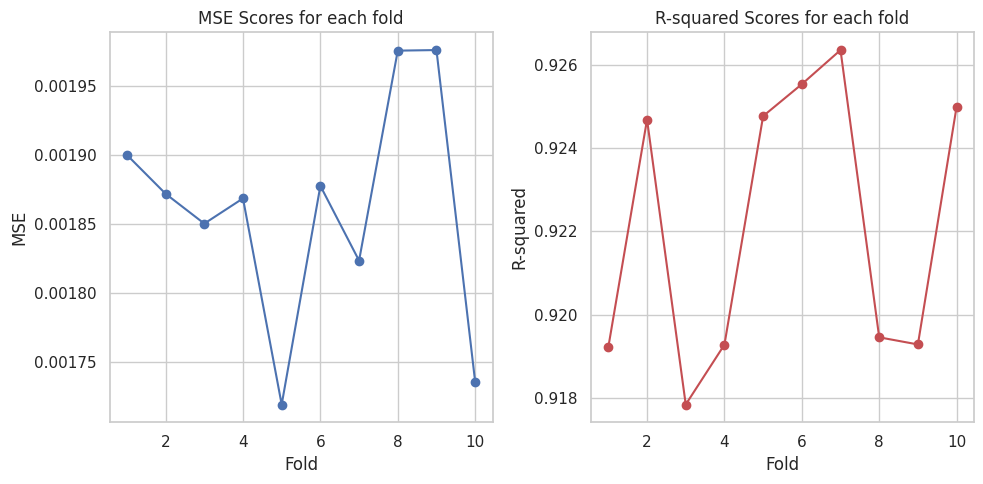

In [ ]:
fold_numbers = np.arange(1, k+1)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(fold_numbers, mse_scores4, marker='o', linestyle='-', color='b')
plt.xlabel('Fold')
plt.ylabel('MSE')
plt.title('MSE Scores for each fold')

plt.subplot(1, 2, 2)
plt.plot(fold_numbers, r2_scores4, marker='o', linestyle='-', color='r')
plt.xlabel('Fold')
plt.ylabel('R-squared')
plt.title('R-squared Scores for each fold')

plt.tight_layout()
plt.show()

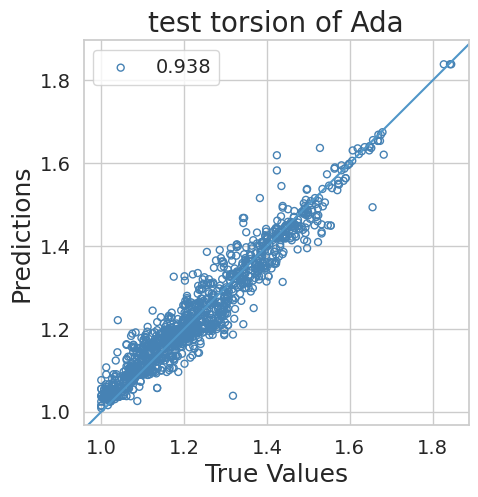

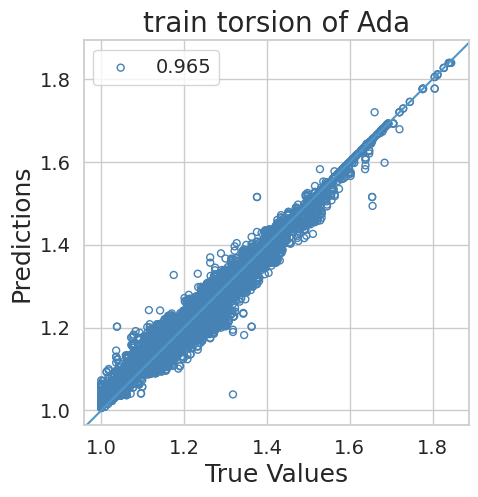

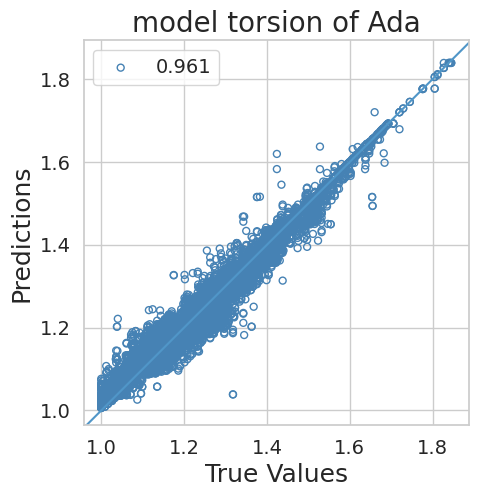

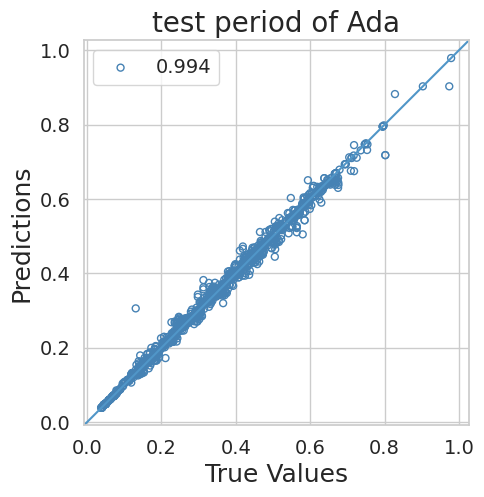

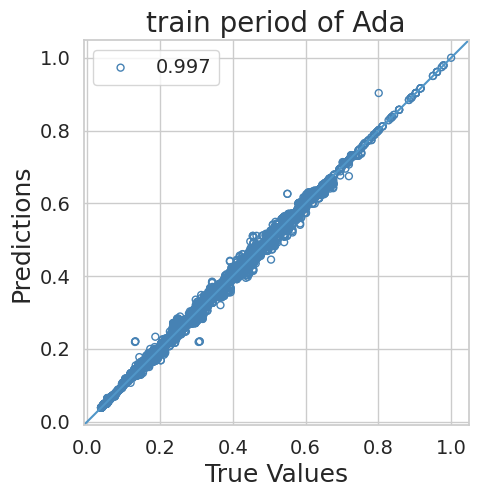

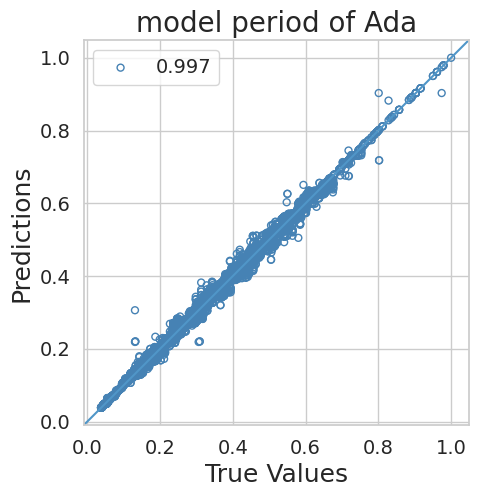

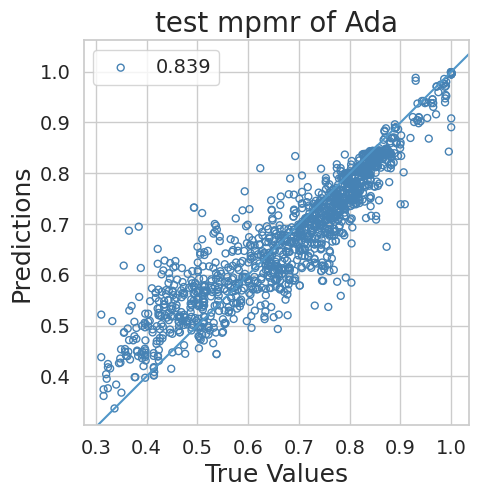

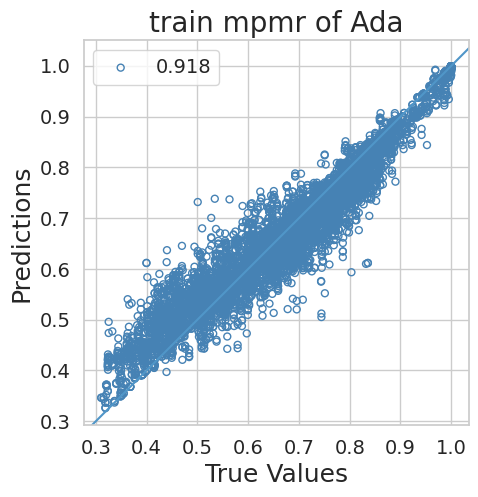

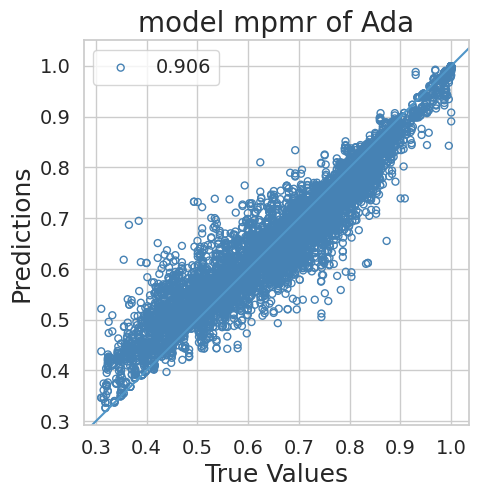

In [ ]:
y_pred_adaboost1 = multioutput_model_ada.predict(X_test_scaled)
y_pred_adaboost2 = multioutput_model_ada.predict(X_train_scaled)
y_pred_adaboost3 = multioutput_model_ada.predict(X_scaled)

r2_tor_test_ada1 = str(round(r2_score(np.array(y_test).T[0], np.array(y_pred_adaboost1).T[0]), 3))
r2_tor_train_ada2 = str(round(r2_score(np.array(y_train).T[0], np.array(y_pred_adaboost2).T[0]), 3))
r2_tor_model_ada3 = str(round(r2_score(np.array(y).T[0], np.array(y_pred_adaboost3).T[0]), 3))
r2_per_test_ada11 = str(round(r2_score(np.array(y_test).T[1], np.array(y_pred_adaboost1 ).T[1]), 3))
r2_per_train_ada22 = str(round(r2_score(np.array(y_train).T[1], np.array(y_pred_adaboost2).T[1]), 3))
r2_per_model_ada33 = str(round(r2_score(np.array(y).T[1], np.array(y_pred_adaboost3).T[1]), 3))
r2_mpmr_test_ada111 = str(round(r2_score(np.array(y_test).T[2], np.array(y_pred_adaboost1).T[2]), 3))
r2_mpmr_train_ada222 = str(round(r2_score(np.array(y_train).T[2], np.array(y_pred_adaboost2).T[2]), 3))
r2_mpmr_model_ada333 = str(round(r2_score(np.array(y).T[2], np.array(y_pred_adaboost3).T[2]), 3))




plot_diff(np.array(y_test).T[0], np.array(y_pred_adaboost1).T[0],r2_tor_test_ada1, title='test torsion of Ada')
plot_diff(np.array(y_train).T[0], np.array(y_pred_adaboost2).T[0],r2_tor_train_ada2, title='train torsion of Ada')
plot_diff(np.array(y).T[0], np.array(y_pred_adaboost3).T[0],r2_tor_model_ada3, title='model torsion of Ada')
plot_diff(np.array(y_test).T[1], np.array(y_pred_adaboost1).T[1],r2_per_test_ada11, title='test period of Ada')
plot_diff(np.array(y_train).T[1], np.array(y_pred_adaboost2).T[1],r2_per_train_ada22, title='train period of Ada')
plot_diff(np.array(y).T[1], np.array(y_pred_adaboost3).T[1],r2_per_model_ada33, title='model period of Ada')
plot_diff(np.array(y_test).T[2], np.array(y_pred_adaboost1).T[2],r2_mpmr_test_ada111, title='test mpmr of Ada')
plot_diff(np.array(y_train).T[2], np.array(y_pred_adaboost2).T[2],r2_mpmr_train_ada222, title='train mpmr of Ada')
plot_diff(np.array(y).T[2], np.array(y_pred_adaboost3).T[2],r2_mpmr_model_ada333, title='model mpmr of Ada')


In [ ]:
mse_ada_1 = mean_squared_error(np.array(y_test).T[0], np.array(y_pred_adaboost1).T[0])
mse_ada_2 = mean_squared_error(np.array(y_train).T[0], np.array(y_pred_adaboost2).T[0])
mse_ada_3 = mean_squared_error(y_0, np.array(y_pred_adaboost3).T[0])
mse_ada_11 = mean_squared_error(np.array(y_test).T[1], np.array(y_pred_adaboost1).T[1])
mse_ada_22 = mean_squared_error(np.array(y_train).T[1], np.array(y_pred_adaboost2).T[1])
mse_ada_33 = mean_squared_error(y_1, np.array(y_pred_adaboost3).T[1])
mse_ada_111 = mean_squared_error(np.array(y_test).T[2], np.array(y_pred_adaboost1).T[2])
mse_ada_222 = mean_squared_error(np.array(y_train).T[2], np.array(y_pred_adaboost2).T[2])
mse_ada_333 = mean_squared_error(y_2, np.array(y_pred_adaboost3).T[2])

rmse_ada_1 = np.sqrt(mse_ada_1)
rmse_ada_2 = np.sqrt(mse_ada_2)
rmse_ada_3 = np.sqrt(mse_ada_3)
rmse_ada_11 = np.sqrt(mse_ada_11)
rmse_ada_22 = np.sqrt(mse_ada_22)
rmse_ada_33 = np.sqrt(mse_ada_33)
rmse_ada_111 = np.sqrt(mse_ada_111)
rmse_ada_222 = np.sqrt(mse_ada_222)
rmse_ada_333 = np.sqrt(mse_ada_333)

mape_ada_1 = mape(np.array(y_test).T[0], np.array(y_pred_adaboost1).T[0])
mape_ada_2 = mape(np.array(y_train).T[0], np.array(y_pred_adaboost2).T[0])
mape_ada_3 = mape(y_0, np.array(y_pred_adaboost3).T[0])
mape_ada_11 = mape(np.array(y_test).T[1], np.array(y_pred_adaboost1).T[1])
mape_ada_22 = mape(np.array(y_train).T[1], np.array(y_pred_adaboost2).T[1])
mape_ada_33 = mape(y_1, np.array(y_pred_adaboost3).T[1])
mape_ada_111 = mape(np.array(y_test).T[2], np.array(y_pred_adaboost1).T[2])
mape_ada_222 = mape(np.array(y_train).T[2], np.array(y_pred_adaboost2).T[2])
mape_ada_333 = mape(y_2, np.array(y_pred_adaboost3).T[2])

mse_torsion4=[mse_ada_1,mse_ada_2,mse_ada_3]
mse_period4=[mse_ada_11,mse_ada_22,mse_ada_33]
mse_mpmr4=[mse_ada_111,mse_ada_222,mse_ada_333]

rmse_torsion4=[rmse_ada_1,rmse_ada_2,rmse_ada_3]
rmse_period4=[rmse_ada_11,rmse_ada_22,rmse_ada_33]
rmse_mpmr4=[rmse_ada_111,rmse_ada_222,rmse_ada_333]

mape_torsion4=[mape_ada_1,mape_ada_2,mape_ada_3]
mape_period4=[mape_ada_11,mape_ada_22,mape_ada_33]
mape_mpmr4=[mape_ada_111,mape_ada_222,mape_ada_333]

print("mse torsion of ada")
print(mse_torsion4)
print("mse period of ada")
print(mse_period4)
print("mse mpmr of ada")
print(mse_mpmr4)
##########
print("rmse torsion of ada")
print(rmse_torsion4)
print("rmse period of ada")
print(rmse_period4)
print("rmse mpmr of ada")
print(rmse_mpmr4)
##########
print("mape torsion of ada")
print(mape_torsion4)
print("mape period of adat")
print(mape_period4)
print("mape mpmr of ada")
print(mape_mpmr4)

mse torsion of ada
[0.001506106929031876, 0.0008541574075682256, 0.0009519867145532576]
mse period of ada
[0.0001814795008103685, 8.910637550435145e-05, 0.00010296756956189326]
mse mpmr of ada
[0.003960227352939857, 0.00190587690720477, 0.002214145682307875]
rmse torsion of ada
[0.03880859349463565, 0.029225971456364384, 0.030854281948430717]
rmse period of ada
[0.013471432767540672, 0.009439617338872983, 0.0101472937062989]
rmse mpmr of ada
[0.06293033730197112, 0.04365635013608868, 0.04705470945939285]
mape torsion of ada
[0.023415062296898333, 0.01857429032321307, 0.019300679946745603]
mape period of adat
[0.02634179169319813, 0.020539264478208575, 0.021409971791452407]
mape mpmr of ada
[0.07698832293247203, 0.052101462890331206, 0.05583589966925576]




---



---


###5. Catboost Algorithm


---



---



In [ ]:
pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 4.5 MB/s eta 0:00:00


Streaming output truncated to the last 5000 lines.
1002:	learn: 0.0215616	total: 6.28s	remaining: 3.11s
1003:	learn: 0.0215578	total: 6.29s	remaining: 3.11s
1004:	learn: 0.0215481	total: 6.32s	remaining: 3.11s
1005:	learn: 0.0215408	total: 6.33s	remaining: 3.11s
1006:	learn: 0.0215291	total: 6.34s	remaining: 3.1s
1007:	learn: 0.0215257	total: 6.34s	remaining: 3.1s
1008:	learn: 0.0215173	total: 6.35s	remaining: 3.09s
1009:	learn: 0.0214960	total: 6.36s	remaining: 3.08s
1010:	learn: 0.0214808	total: 6.37s	remaining: 3.08s
1011:	learn: 0.0214773	total: 6.38s	remaining: 3.07s
1012:	learn: 0.0214633	total: 6.38s	remaining: 3.07s
1013:	learn: 0.0214601	total: 6.39s	remaining: 3.06s
1014:	learn: 0.0214497	total: 6.39s	remaining: 3.06s
1015:	learn: 0.0214384	total: 6.4s	remaining: 3.05s
1016:	learn: 0.0214143	total: 6.41s	remaining: 3.04s
1017:	learn: 0.0214044	total: 6.41s	remaining: 3.04s
1018:	learn: 0.0213921	total: 6.42s	remaining: 3.03s
1019:	learn: 0.0213750	total: 6.43s	remaining: 3.02

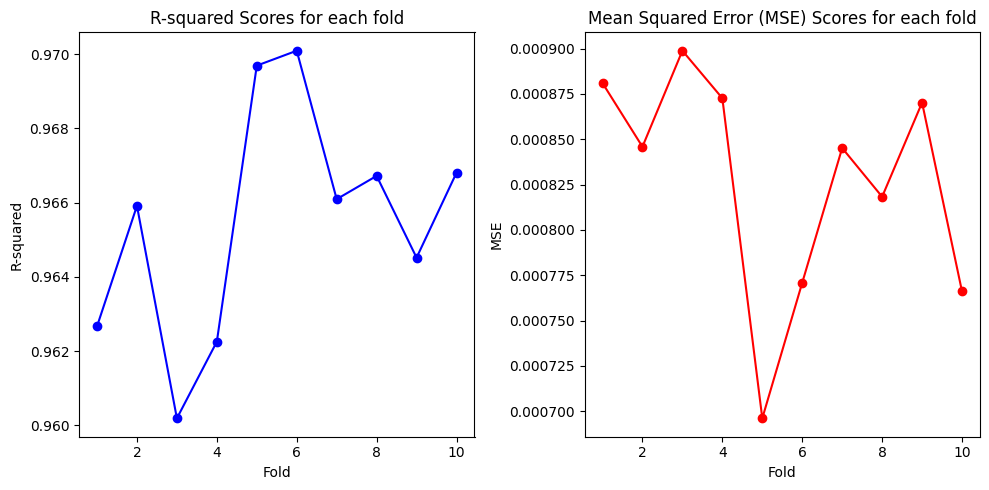

R2 of test mpmr: 0.923
R2 of train mpmr: 0.981
R2 of model mpmr: 0.972
Mean squared error: 0.00


In [ ]:
from catboost import CatBoostRegressor
from sklearn.multioutput import MultiOutputRegressor
# Create a CatBoostRegressor object
catboost_model = CatBoostRegressor(iterations=1500, learning_rate=0.2, depth=8,  subsample=0.8, l2_leaf_reg=8)
multioutput_model = MultiOutputRegressor(catboost_model)
mse_scores = []  # To store mean squared error scores for each fold
r2_scores = []
k = 10 # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=32)
for train_index, val_index in kf.split(X_train_scaled):
    X_train0, X_val0 = X_train_scaled[train_index], X_train_scaled[val_index]
    y_train0, y_val0 = np.array(y_train)[train_index], np.array(y_train)[val_index]

    # Fit to the training data
    multioutput_model.fit(X_train0, y_train0)
    y_pred1 = multioutput_model.predict(X_val0)

    mse = mean_squared_error(y_val0, y_pred1)  # Calculate mean squared error
    mse_scores.append(mse)

    r2 = r2_score(y_val0, y_pred1)  # Calculate R-squared
    r2_scores.append(r2)

average_mse = np.mean(mse_scores)
average_r2 = np.mean(r2_scores)
print("Average Mean Squared Error:", average_mse)
print("Average R-squared:", average_r2)
# Plot R-squared and MSE scores
fold_numbers = np.arange(1, k+1)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(fold_numbers, r2_scores, marker='o', linestyle='-', color='b')
plt.xlabel('Fold')
plt.ylabel('R-squared')
plt.title('R-squared Scores for each fold')

plt.subplot(1, 2, 2)
plt.plot(fold_numbers, mse_scores, marker='o', linestyle='-', color='r')
plt.xlabel('Fold')
plt.ylabel('MSE')
plt.title('Mean Squared Error (MSE) Scores for each fold')

plt.tight_layout()
plt.show()


# Get the best model

# Make predictions on the test data using the best model
predictions1 = multioutput_model.predict(X_test_scaled)
predictions2 = multioutput_model.predict(X_train_scaled)
predictions3 = multioutput_model.predict(X_scaled)


#print (predictions)
r1 = str(round(r2_score(y_test_0, predictions1.T[0]), 3))
r2 = str(round(r2_score(y_train_0, predictions2.T[0]), 3))
r3 = str(round(r2_score(y_0, predictions3.T[0]), 3))
r11 = str(round(r2_score(y_test_1, predictions1.T[1]), 3))
r22= str(round(r2_score(y_train_1, predictions2.T[1]), 3))
r33 = str(round(r2_score(y_1, predictions3.T[1]), 3))
r111 = str(round(r2_score(y_test_2, predictions1.T[2]), 3))
r222 = str(round(r2_score(y_train_2, predictions2.T[2]), 3))
r333 = str(round(r2_score(y_2, predictions3.T[2]), 3))


print("R2 of test mpmr:", r111)
print("R2 of train mpmr:", r222)
print("R2 of model mpmr:" ,r333)

# Calculate the accuracy
mse = mean_squared_error(y_test, predictions1)
print("Mean squared error: {:.2f}".format(mse))

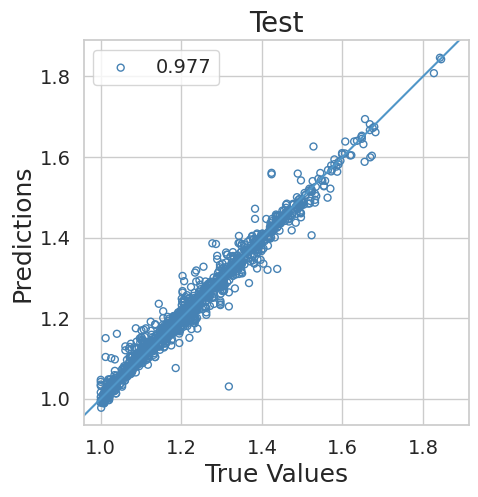

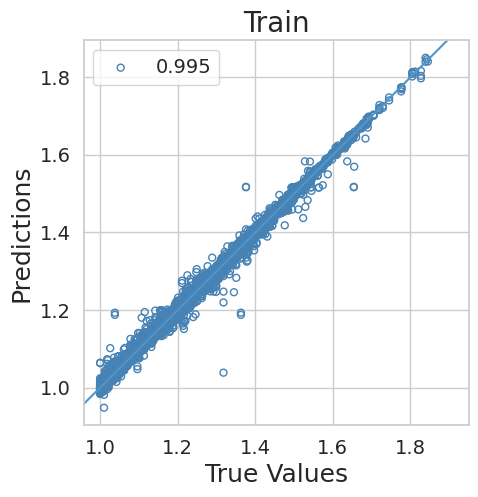

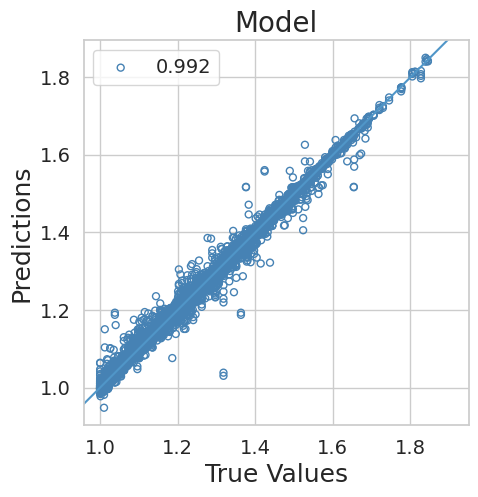

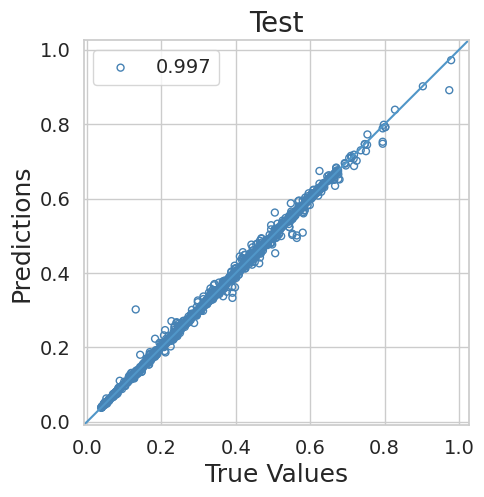

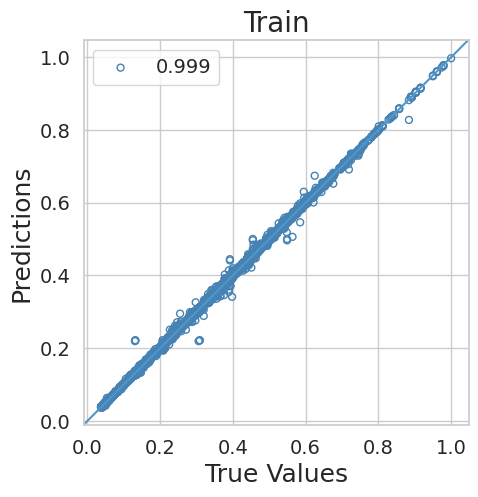

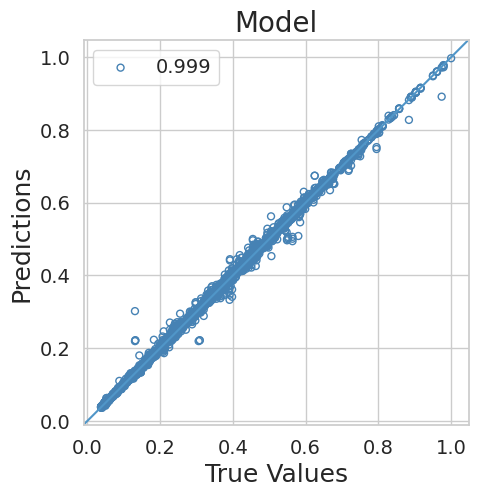

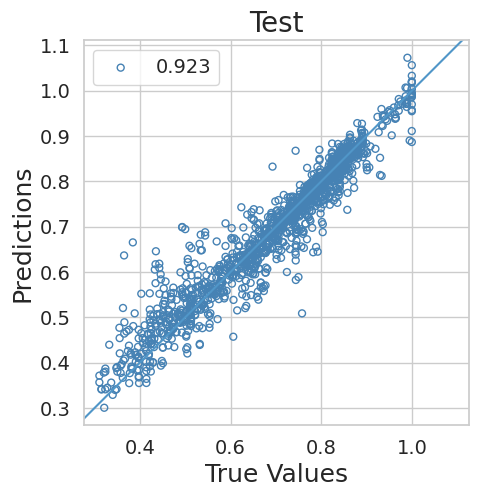

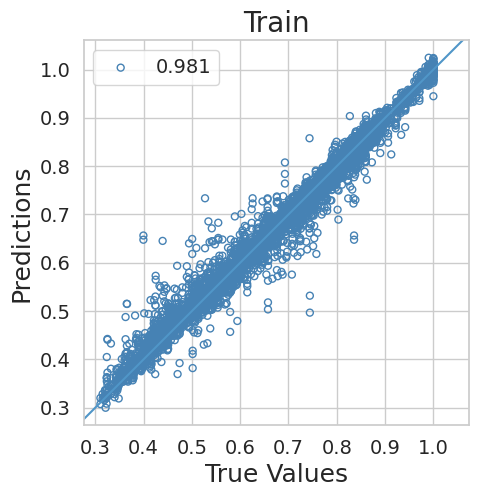

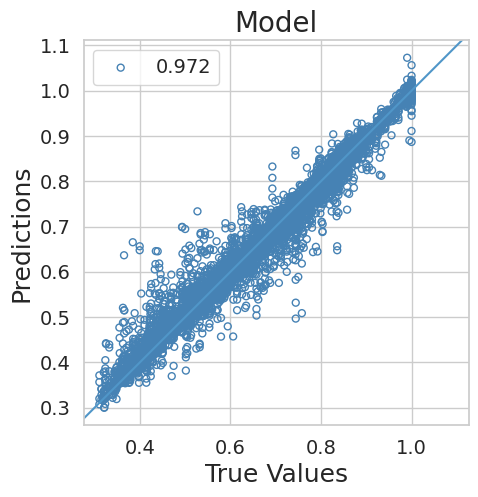

In [ ]:
#scatter plot for CatBoost algorithm results
plot_diff(np.array(y_test).T[0], np.array(predictions1).T[0],r1, title='Test')
plot_diff(np.array(y_train).T[0], np.array(predictions2).T[0],r2, title='Train')
plot_diff(y_0, np.array(predictions3).T[0],r3, title='Model')

plot_diff(np.array(y_test).T[1], np.array(predictions1).T[1],r11, title='Test')
plot_diff(np.array(y_train).T[1], np.array(predictions2).T[1],r22, title='Train')
plot_diff(y_1, np.array(predictions3).T[1],r33, title='Model')

plot_diff(np.array(y_test).T[2], np.array(predictions1).T[2],r111, title='Test')
plot_diff(np.array(y_train).T[2], np.array(predictions2).T[2],r222, title='Train')
plot_diff(y_2, np.array(predictions3).T[2],r333, title='Model')

In [ ]:
mse_cat_1 = mean_squared_error(np.array(y_test).T[0], np.array(predictions1).T[0])
mse_cat_2 = mean_squared_error(np.array(y_train).T[0], np.array(predictions2).T[0])
mse_cat_3 = mean_squared_error(y_0, np.array(predictions3).T[0])
mse_cat_11 = mean_squared_error(np.array(y_test).T[1], np.array(predictions1).T[1])
mse_cat_22 = mean_squared_error(np.array(y_train).T[1], np.array(predictions2).T[1])
mse_cat_33 = mean_squared_error(y_1, np.array(predictions3).T[1])
mse_cat_111 = mean_squared_error(np.array(y_test).T[2], np.array(predictions1).T[2])
mse_cat_222 = mean_squared_error(np.array(y_train).T[2], np.array(predictions2).T[2])
mse_cat_333 = mean_squared_error(y_2, np.array(predictions3).T[2])

rmse_cat_1 = np.sqrt(mse_cat_1)
rmse_cat_2 = np.sqrt(mse_cat_2)
rmse_cat_3 = np.sqrt(mse_cat_3)
rmse_cat_11 = np.sqrt(mse_cat_11)
rmse_cat_22 = np.sqrt(mse_cat_22)
rmse_cat_33 = np.sqrt(mse_cat_33)
rmse_cat_111 = np.sqrt(mse_cat_111)
rmse_cat_222 = np.sqrt(mse_cat_222)
rmse_cat_333 = np.sqrt(mse_cat_333)

mape_cat_1 = mape(np.array(y_test).T[0], np.array(predictions1).T[0])
mape_cat_2 = mape(np.array(y_train).T[0], np.array(predictions2).T[0])
mape_cat_3 = mape(y_0, np.array(predictions3).T[0])
mape_cat_11 = mape(np.array(y_test).T[1], np.array(predictions1).T[1])
mape_cat_22 = mape(np.array(y_train).T[1], np.array(predictions2).T[1])
mape_cat_33 = mape(y_1, np.array(predictions3).T[1])
mape_cat_111 = mape(np.array(y_test).T[2], np.array(predictions1).T[2])
mape_cat_222 = mape(np.array(y_train).T[2], np.array(predictions2).T[2])
mape_cat_333 = mape(y_2, np.array(predictions3).T[2])

mse_torsion5=[mse_cat_1,mse_cat_2,mse_cat_3]
mse_period5=[mse_cat_11,mse_cat_22,mse_cat_33]
mse_mpmr5=[mse_cat_111,mse_cat_222,mse_cat_333]

rmse_torsion5=[rmse_cat_1,rmse_cat_2,rmse_cat_3]
rmse_period5=[rmse_cat_11,rmse_cat_22,rmse_cat_33]
rmse_mpmr5=[rmse_cat_111,rmse_cat_222,rmse_cat_333]

mape_torsion5=[mape_cat_1,mape_cat_2,mape_cat_3]
mape_period5=[mape_cat_11,mape_cat_22,mape_cat_33]
mape_mpmr5=[mape_cat_111,mape_cat_222,mape_cat_333]

print("mse torsion of dt")
print(mse_torsion5)
print("mse period of dt")
print(mse_period5)
print("mse mpmr of dt")
print(mse_mpmr5)
##########
print("rmse torsion of dt")
print(rmse_torsion5)
print("rmse period of dt")
print(rmse_period5)
print("rmse mpmr of dt")
print(rmse_mpmr5)
##########
print("mape torsion of dt")
print(mape_torsion5)
print("mape period of dt")
print(mape_period5)
print("mape mpmr of dt")
print(mape_mpmr5)

mse torsion of dt
[0.0005507143129876991, 0.00011857503010659991, 0.0001834203673197567]
mse period of dt
[0.00010329678335676828, 1.812272161588011e-05, 3.0903648909920615e-05]
mse mpmr of dt
[0.001896319696254576, 0.00043622209377186137, 0.0006553193273440387]
rmse torsion of dt
[0.02346730306165792, 0.010889216230133366, 0.013543277569324077]
rmse period of dt
[0.01016350251423043, 0.004257079000427419, 0.0055591050457713615]
rmse mpmr of dt
[0.04354675299324366, 0.02088593052204908, 0.02559920559986264]
mape torsion of dt
[0.011600499833379288, 0.005054727164044899, 0.006036963338534138]
mape period of dt
[0.0174867886985109, 0.007597393293981076, 0.009081362017133296]
mape mpmr of dt
[0.04677317596487126, 0.019827530891294902, 0.023870901884028406]


<ipython-input-70-06774cc9f23e>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_0, bins=30, hist_kws={'edgecolor': 'black', 'alpha': 0.6, 'color': 'red'}, kde_kws={'color': 'red', 'linewidth': 3}, norm_hist=True)
<ipython-input-70-06774cc9f23e>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax1=sns.dist

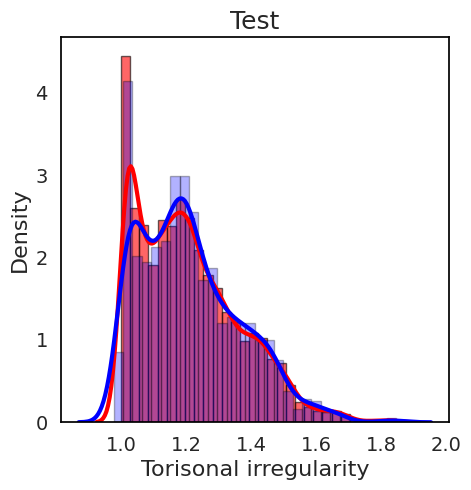

<ipython-input-70-06774cc9f23e>:21: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_1, bins=30, hist_kws={'edgecolor': 'black', 'alpha': 0.6, 'color': 'red'}, kde_kws={'color': 'red', 'linewidth': 3}, norm_hist=True)
<ipython-input-70-06774cc9f23e>:22: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax2=sns.di

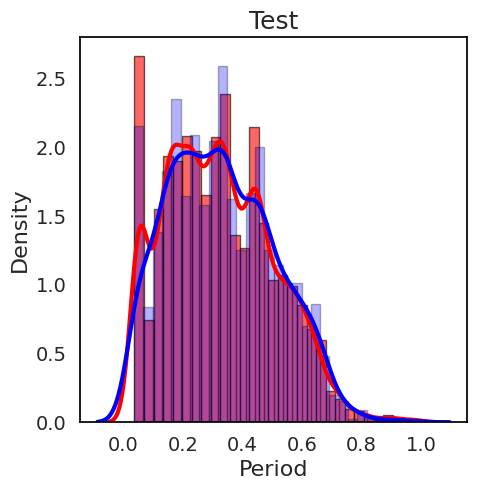

<ipython-input-70-06774cc9f23e>:39: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_2, bins=30, hist_kws={'edgecolor': 'black', 'alpha': 0.6, 'color': 'red'}, kde_kws={'color': 'red', 'linewidth': 3}, norm_hist=True)
<ipython-input-70-06774cc9f23e>:40: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax3=sns.di

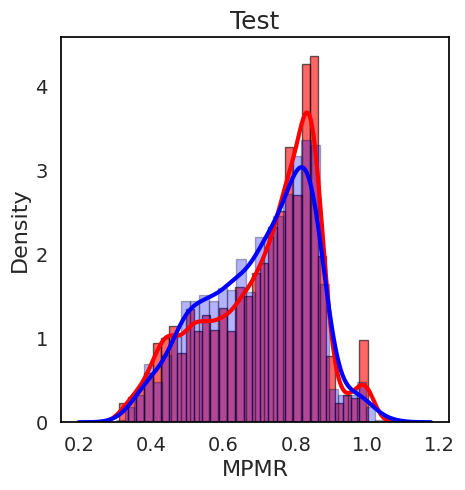

In [ ]:
fig= plt.subplots(figsize=(5,5))
sns.set(style="whitegrid")
sns.distplot(y_0, bins=30, hist_kws={'edgecolor': 'black', 'alpha': 0.6, 'color': 'red'}, kde_kws={'color': 'red', 'linewidth': 3}, norm_hist=True)
ax1=sns.distplot(predictions1[:,0], bins=30, hist_kws={'edgecolor': 'black', 'alpha': 0.3, 'color': 'blue'}, kde_kws={'color': 'blue', 'linewidth': 3}, norm_hist=True)
for spine in ax1.spines.values():
    spine.set_edgecolor('black')
plt.xlabel('Torisonal irregularity')
xlabel = plt.gca().xaxis.get_label()
xlabel.set_size(16)
plt.xticks(fontsize=14)
plt.ylabel('Density')
ylabel = plt.gca().yaxis.get_label()
ylabel.set_size(16)
plt.yticks(fontsize=14)
plt.title('Test', fontsize=18)
plt.grid(False)
plt.show()

fig= plt.subplots(figsize=(5,5))
sns.set(style="whitegrid")
sns.distplot(y_1, bins=30, hist_kws={'edgecolor': 'black', 'alpha': 0.6, 'color': 'red'}, kde_kws={'color': 'red', 'linewidth': 3}, norm_hist=True)
ax2=sns.distplot(predictions1[:,1], bins=30, hist_kws={'edgecolor': 'black', 'alpha': 0.3, 'color': 'blue'}, kde_kws={'color': 'blue', 'linewidth': 3}, norm_hist=True)
for spine in ax2.spines.values():
    spine.set_edgecolor('black')
plt.xlabel('Period')
xlabel = plt.gca().xaxis.get_label()
xlabel.set_size(16)
plt.xticks(fontsize=14)
plt.ylabel('Density')
ylabel = plt.gca().yaxis.get_label()
ylabel.set_size(16)
plt.yticks(fontsize=14)
plt.title('Test', fontsize=18)
plt.grid(False)
plt.show()

fig= plt.subplots(figsize=(5,5))
sns.set(style="whitegrid")
sns.distplot(y_2, bins=30, hist_kws={'edgecolor': 'black', 'alpha': 0.6, 'color': 'red'}, kde_kws={'color': 'red', 'linewidth': 3}, norm_hist=True)
ax3=sns.distplot(predictions1[:,2], bins=30, hist_kws={'edgecolor': 'black', 'alpha': 0.3, 'color': 'blue'}, kde_kws={'color': 'blue', 'linewidth': 3}, norm_hist=True)
for spine in ax3.spines.values():
    spine.set_edgecolor('black')
plt.xlabel('MPMR')
xlabel = plt.gca().xaxis.get_label()
xlabel.set_size(16)
plt.xticks(fontsize=14)
plt.ylabel('Density')
ylabel = plt.gca().yaxis.get_label()
ylabel.set_size(16)
plt.yticks(fontsize=14)
plt.title('Test', fontsize=18)
plt.grid(False)
plt.show()

<ipython-input-71-245e4839cfc8>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_0, bins=30, hist_kws={'edgecolor': 'black', 'alpha': 0.6, 'color': 'red'}, kde_kws={'color': 'red', 'linewidth': 3}, norm_hist=True)
<ipython-input-71-245e4839cfc8>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax1=sns.dist

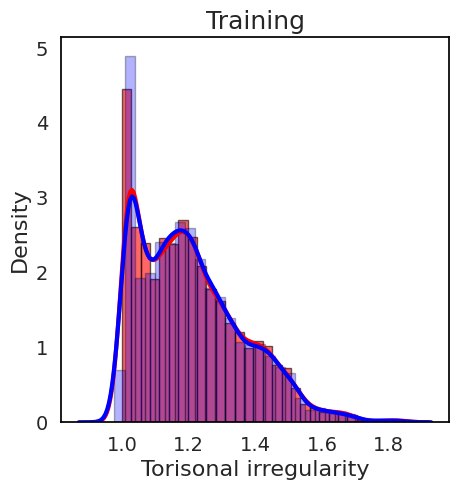

<ipython-input-71-245e4839cfc8>:22: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_1, bins=30, hist_kws={'edgecolor': 'black', 'alpha': 0.6, 'color': 'red'}, kde_kws={'color': 'red', 'linewidth': 3}, norm_hist=True)
<ipython-input-71-245e4839cfc8>:23: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax2=sns.di

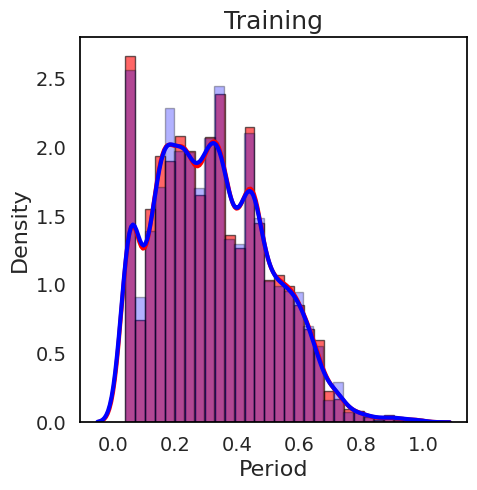

<ipython-input-71-245e4839cfc8>:40: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_2, bins=30, hist_kws={'edgecolor': 'black', 'alpha': 0.6, 'color': 'red'}, kde_kws={'color': 'red', 'linewidth': 3}, norm_hist=True)
<ipython-input-71-245e4839cfc8>:41: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax3=sns.di

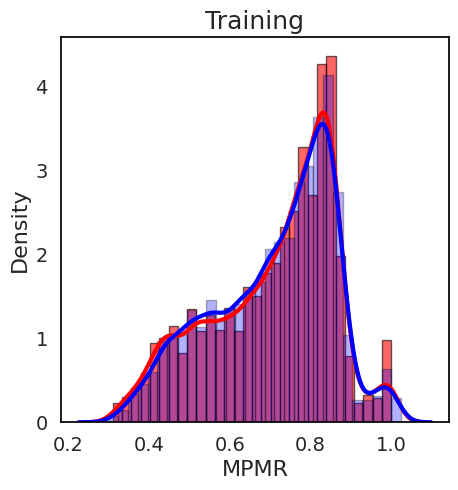

In [ ]:
#training
fig= plt.subplots(figsize=(5,5))
sns.set(style="whitegrid")
sns.distplot(y_0, bins=30, hist_kws={'edgecolor': 'black', 'alpha': 0.6, 'color': 'red'}, kde_kws={'color': 'red', 'linewidth': 3}, norm_hist=True)
ax1=sns.distplot(predictions2[:,0], bins=30, hist_kws={'edgecolor': 'black', 'alpha': 0.3, 'color': 'blue'}, kde_kws={'color': 'blue', 'linewidth': 3}, norm_hist=True)
for spine in ax1.spines.values():
    spine.set_edgecolor('black')
plt.xlabel('Torisonal irregularity')
xlabel = plt.gca().xaxis.get_label()
xlabel.set_size(16)
plt.xticks(fontsize=14)
plt.ylabel('Density')
ylabel = plt.gca().yaxis.get_label()
ylabel.set_size(16)
plt.yticks(fontsize=14)
plt.title('Training', fontsize=18)
plt.grid(False)
plt.show()

fig= plt.subplots(figsize=(5,5))
sns.set(style="whitegrid")
sns.distplot(y_1, bins=30, hist_kws={'edgecolor': 'black', 'alpha': 0.6, 'color': 'red'}, kde_kws={'color': 'red', 'linewidth': 3}, norm_hist=True)
ax2=sns.distplot(predictions2[:,1], bins=30, hist_kws={'edgecolor': 'black', 'alpha': 0.3, 'color': 'blue'}, kde_kws={'color': 'blue', 'linewidth': 3}, norm_hist=True)
for spine in ax2.spines.values():
    spine.set_edgecolor('black')
plt.xlabel('Period')
xlabel = plt.gca().xaxis.get_label()
xlabel.set_size(16)
plt.xticks(fontsize=14)
plt.ylabel('Density')
ylabel = plt.gca().yaxis.get_label()
ylabel.set_size(16)
plt.yticks(fontsize=14)
plt.title('Training', fontsize=18)
plt.grid(False)
plt.show()

fig= plt.subplots(figsize=(5,5))
sns.set(style="whitegrid")
sns.distplot(y_2, bins=30, hist_kws={'edgecolor': 'black', 'alpha': 0.6, 'color': 'red'}, kde_kws={'color': 'red', 'linewidth': 3}, norm_hist=True)
ax3=sns.distplot(predictions2[:,2], bins=30, hist_kws={'edgecolor': 'black', 'alpha': 0.3, 'color': 'blue'}, kde_kws={'color': 'blue', 'linewidth': 3}, norm_hist=True)
for spine in ax3.spines.values():
    spine.set_edgecolor('black')
plt.xlabel('MPMR')
xlabel = plt.gca().xaxis.get_label()
xlabel.set_size(16)
plt.xticks(fontsize=14)
plt.ylabel('Density')
ylabel = plt.gca().yaxis.get_label()
ylabel.set_size(16)
plt.yticks(fontsize=14)
plt.title('Training', fontsize=18)
plt.grid(False)
plt.show()

<ipython-input-72-ade7c9425563>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_0, bins=30, hist_kws={'edgecolor': 'black', 'alpha': 0.6, 'color': 'red'}, kde_kws={'color': 'red', 'linewidth': 3}, norm_hist=True)
<ipython-input-72-ade7c9425563>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax1=sns.dist

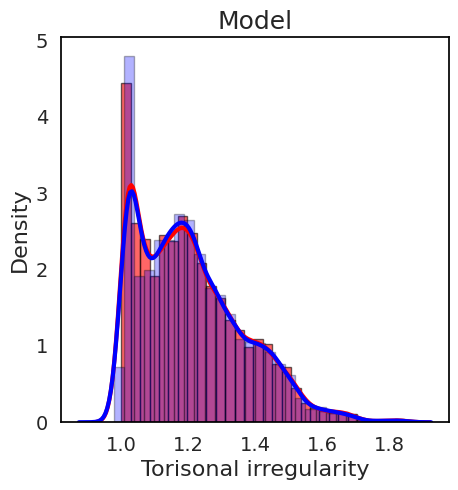

<ipython-input-72-ade7c9425563>:22: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_1, bins=30, hist_kws={'edgecolor': 'black', 'alpha': 0.6, 'color': 'red'}, kde_kws={'color': 'red', 'linewidth': 3}, norm_hist=True)
<ipython-input-72-ade7c9425563>:23: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax2=sns.di

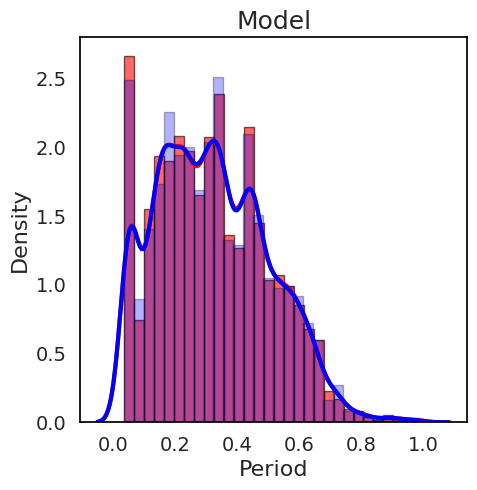

<ipython-input-72-ade7c9425563>:40: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_2, bins=30, hist_kws={'edgecolor': 'black', 'alpha': 0.6, 'color': 'red'}, kde_kws={'color': 'red', 'linewidth': 3}, norm_hist=True)
<ipython-input-72-ade7c9425563>:41: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax3=sns.di

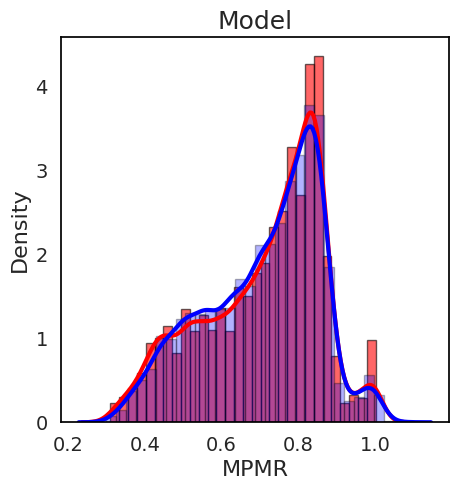

In [ ]:
#model
fig= plt.subplots(figsize=(5,5))
sns.set(style="whitegrid")
sns.distplot(y_0, bins=30, hist_kws={'edgecolor': 'black', 'alpha': 0.6, 'color': 'red'}, kde_kws={'color': 'red', 'linewidth': 3}, norm_hist=True)
ax1=sns.distplot(predictions3[:,0], bins=30, hist_kws={'edgecolor': 'black', 'alpha': 0.3, 'color': 'blue'}, kde_kws={'color': 'blue', 'linewidth': 3}, norm_hist=True)
for spine in ax1.spines.values():
    spine.set_edgecolor('black')
plt.xlabel('Torisonal irregularity')
xlabel = plt.gca().xaxis.get_label()
xlabel.set_size(16)
plt.xticks(fontsize=14)
plt.ylabel('Density')
ylabel = plt.gca().yaxis.get_label()
ylabel.set_size(16)
plt.yticks(fontsize=14)
plt.title('Model', fontsize=18)
plt.grid(False)
plt.show()

fig= plt.subplots(figsize=(5,5))
sns.set(style="whitegrid")
sns.distplot(y_1, bins=30, hist_kws={'edgecolor': 'black', 'alpha': 0.6, 'color': 'red'}, kde_kws={'color': 'red', 'linewidth': 3}, norm_hist=True)
ax2=sns.distplot(predictions3[:,1], bins=30, hist_kws={'edgecolor': 'black', 'alpha': 0.3, 'color': 'blue'}, kde_kws={'color': 'blue', 'linewidth': 3}, norm_hist=True)
for spine in ax2.spines.values():
    spine.set_edgecolor('black')
plt.xlabel('Period')
xlabel = plt.gca().xaxis.get_label()
xlabel.set_size(16)
plt.xticks(fontsize=14)
plt.ylabel('Density')
ylabel = plt.gca().yaxis.get_label()
ylabel.set_size(16)
plt.yticks(fontsize=14)
plt.title('Model', fontsize=18)
plt.grid(False)
plt.show()

fig= plt.subplots(figsize=(5,5))
sns.set(style="whitegrid")
sns.distplot(y_2, bins=30, hist_kws={'edgecolor': 'black', 'alpha': 0.6, 'color': 'red'}, kde_kws={'color': 'red', 'linewidth': 3}, norm_hist=True)
ax3=sns.distplot(predictions3[:,2], bins=30, hist_kws={'edgecolor': 'black', 'alpha': 0.3, 'color': 'blue'}, kde_kws={'color': 'blue', 'linewidth': 3}, norm_hist=True)
for spine in ax3.spines.values():
    spine.set_edgecolor('black')
plt.xlabel('MPMR')
xlabel = plt.gca().xaxis.get_label()
xlabel.set_size(16)
plt.xticks(fontsize=14)
plt.ylabel('Density')
ylabel = plt.gca().yaxis.get_label()
ylabel.set_size(16)
plt.yticks(fontsize=14)
plt.title('Model', fontsize=18)
plt.grid(False)
plt.show()

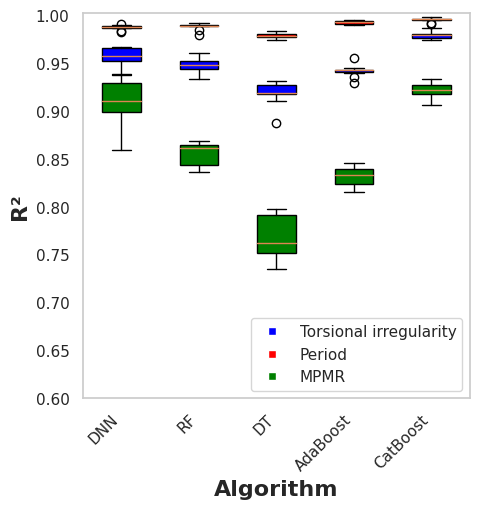

In [ ]:
#Boxplot for R2 results of validation set
import matplotlib.patches as mpatches
#period

data_to_plot11 = [r2_scores_per2, r2_scores_per1, r2_scores_per3, r2_scores_per4, r2_scores_per5]
data_to_plot22=[r2_scores_tor2, r2_scores_tor1, r2_scores_tor3, r2_scores_tor4, r2_scores_tor5]
data_to_plot33=[r2_scores_mpmr2, r2_scores_mpmr1, r2_scores_mpmr3, r2_scores_mpmr4, r2_scores_mpmr5]

fig, ax = plt.subplots(figsize=(5, 5))
# Create a box plot
boxplot = plt.boxplot(data_to_plot11, vert=True, patch_artist=True,  boxprops=dict(facecolor='red'))
boxplot2 = plt.boxplot(data_to_plot22, vert=True, patch_artist=True,  boxprops=dict(facecolor='blue'))
boxplot3 = plt.boxplot(data_to_plot33, vert=True, patch_artist=True,  boxprops=dict(facecolor='green'))

x_axis_labels = ['DNN', 'RF', 'DT', 'AdaBoost', 'CatBoost']

plt.ylim(0.6, 1.002)
plt.xlabel('Algorithm', fontsize=16, fontweight='bold')
plt.ylabel('R²', fontsize=16,fontweight='bold')
plt.title('', fontsize=16,fontweight='bold')
plt.grid(False)
database_labels = ['Torsional irregularity', 'Period', 'MPMR']

legend_handles = []
for color, label in zip(['blue', 'red', 'green'], database_labels):
    legend_handles.append(plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=color, label=label))
ax.set_xticks(np.arange(1, len(x_axis_labels) + 1))
ax.set_xticklabels(x_axis_labels,rotation=45, ha='right')
plt.legend(handles=legend_handles, loc='lower right')

plt.show()


In [ ]:
from catboost import CatBoostClassifier, CatBoostRegressor, Pool

#Feature importance for Torsion
y_7=pd.DataFrame(y_0)
catboost1=catboost_model.fit(X_scaled, y_7)
# Get feature importance scores
importances1 = catboost1.get_feature_importance(Pool(X_scaled, label=y_7))
shap_values1 = catboost1.get_feature_importance(data=Pool(X_scaled, label=y_7), type="ShapValues")

# Get feature names
feature_names = x.columns
# Create a DataFrame for easier sorting and visualization
feature_importance_df1 = pd.DataFrame({'Feature': feature_names, 'Importance': importances1})
feature_importance_df1 = feature_importance_df1.sort_values(by='Importance', ascending=False)


#Feature importance for Period
y_8=pd.DataFrame(y_1)
catboost2=catboost_model.fit(X_scaled, y_8)
# Get feature importance scores
importances2 = catboost2.get_feature_importance(Pool(X_scaled, label=y_8))
shap_values2 = catboost2.get_feature_importance(data=Pool(X_scaled, label=y_8), type="ShapValues")

# Get feature names
feature_names = x.columns
# Create a DataFrame for easier sorting and visualization
feature_importance_df2 = pd.DataFrame({'Feature': feature_names, 'Importance': importances2})
feature_importance_df2 = feature_importance_df2.sort_values(by='Importance', ascending=False)


#Feature importance for MPMR
y_9=pd.DataFrame(y_2)
catboost3=catboost_model.fit(X_scaled, y_9)
# Get feature importance scores
importances3 = catboost3.get_feature_importance(Pool(X_scaled, label=y_9))
shap_values3 = catboost3.get_feature_importance(data=Pool(X_scaled, label=y_9), type="ShapValues")

# Get feature names
feature_names = x.columns
# Create a DataFrame for easier sorting and visualization
feature_importance_df3 = pd.DataFrame({'Feature': feature_names, 'Importance': importances3})
feature_importance_df3 = feature_importance_df3.sort_values(by='Importance', ascending=False)


0:	learn: 0.1363928	total: 17.8ms	remaining: 26.7s
1:	learn: 0.1202413	total: 42.3ms	remaining: 31.7s
2:	learn: 0.1062234	total: 60ms	remaining: 29.9s
3:	learn: 0.0958563	total: 74.9ms	remaining: 28s
4:	learn: 0.0868878	total: 89.4ms	remaining: 26.7s
5:	learn: 0.0795999	total: 105ms	remaining: 26.1s
6:	learn: 0.0741873	total: 123ms	remaining: 26.1s
7:	learn: 0.0695353	total: 136ms	remaining: 25.4s
8:	learn: 0.0659616	total: 152ms	remaining: 25.2s
9:	learn: 0.0631114	total: 166ms	remaining: 24.8s
10:	learn: 0.0611872	total: 179ms	remaining: 24.2s
11:	learn: 0.0592695	total: 196ms	remaining: 24.4s
12:	learn: 0.0576143	total: 216ms	remaining: 24.7s
13:	learn: 0.0562390	total: 232ms	remaining: 24.6s
14:	learn: 0.0552395	total: 246ms	remaining: 24.4s
15:	learn: 0.0540690	total: 259ms	remaining: 24s
16:	learn: 0.0527691	total: 272ms	remaining: 23.7s
17:	learn: 0.0518446	total: 286ms	remaining: 23.5s
18:	learn: 0.0510005	total: 304ms	remaining: 23.7s
19:	learn: 0.0502861	total: 316ms	remainin

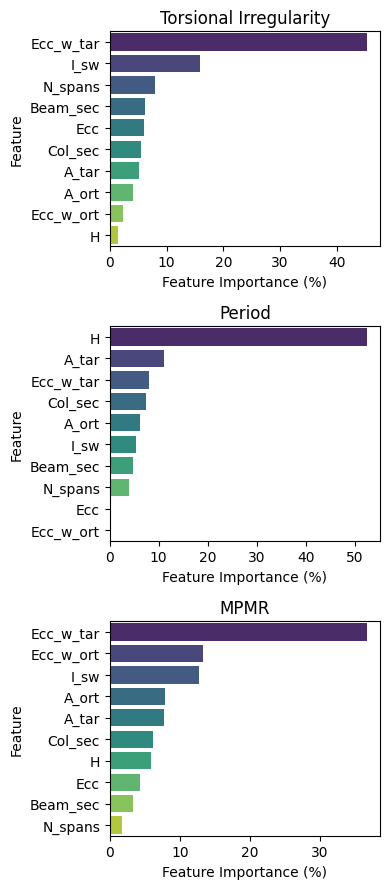

In [ ]:
# Create subplots
plt.figure(figsize=(4, 9))

# First subplot
ax1=plt.subplot(3, 1, 1)
sns.barplot(data=feature_importance_df1, x='Importance', y='Feature', palette='viridis')
plt.xlabel('Feature Importance (%)')
plt.ylabel('Feature')
plt.title('Torsional Irregularity')
ax1.spines['top'].set_color('black')
ax1.spines['right'].set_color('black')
ax1.spines['bottom'].set_color('black')
ax1.spines['left'].set_color('black')

# Second subplot
ax2=plt.subplot(3, 1, 2)
sns.barplot(data=feature_importance_df2, x='Importance', y='Feature', palette='viridis')
plt.xlabel('Feature Importance (%)')
plt.ylabel('Feature')
plt.title('Period')
ax2.spines['top'].set_color('black')
ax2.spines['right'].set_color('black')
ax2.spines['bottom'].set_color('black')
ax2.spines['left'].set_color('black')

# Third subplot
ax3=plt.subplot(3, 1, 3)
sns.barplot(data=feature_importance_df3, x='Importance', y='Feature', palette='viridis')
plt.xlabel('Feature Importance (%)')
plt.ylabel('Feature')
plt.title('MPMR')
ax3.spines['top'].set_color('black')
ax3.spines['right'].set_color('black')
ax3.spines['bottom'].set_color('black')
ax3.spines['left'].set_color('black')
plt.tight_layout()
plt.show()


In [ ]:
pip install minepy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.0/497.0 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for minepy: filename=minepy-1.2.6-cp310-cp310-linux_x86_64.whl size=187014 sha256=4248452251ce4a2fae945d7dcdb256c4fcd72df7aba43d9bebdc26c273d9b103
  Stored in directory: /root/.cache/pip/wheels/69/38/a6/825bb9b9ed81e6af43a0ef80c7cfe4cafcfdbc2f5cde2959d9
Successfully built minepy


<Axes: >

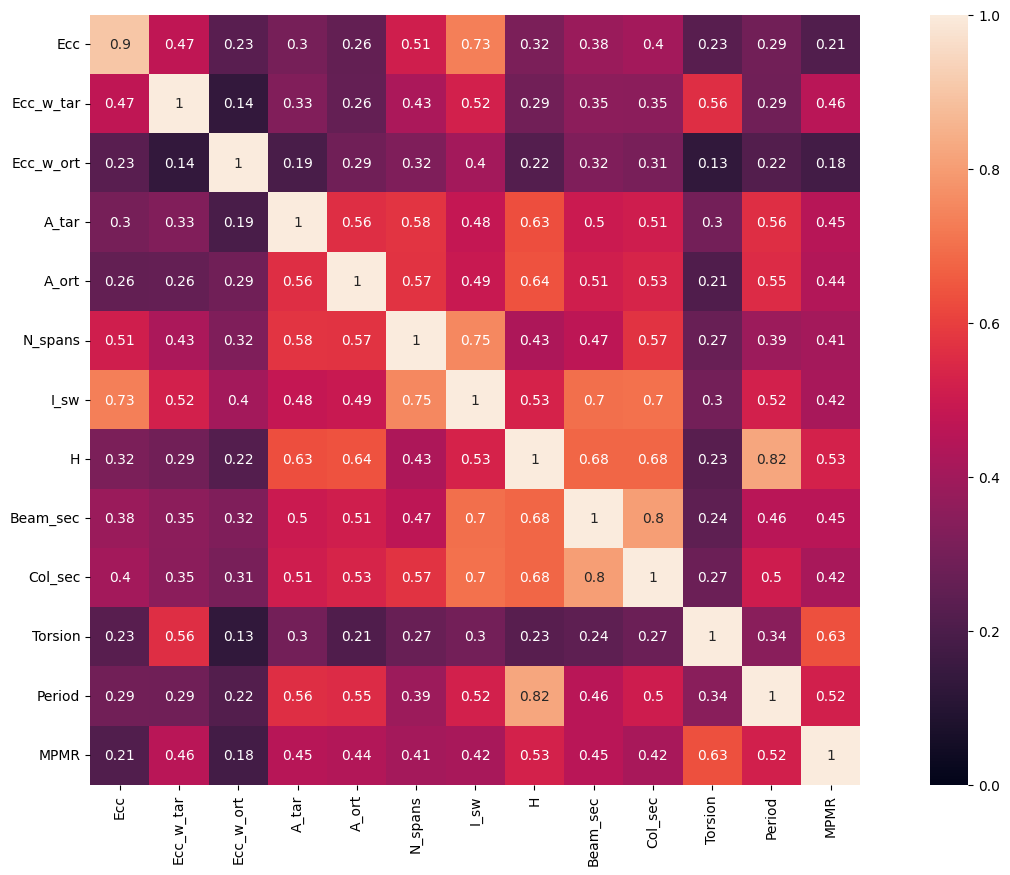

In [ ]:
import numpy as np
from minepy import MINE

#correlation by MIc method
feature_names2 = ['Ecc','Ecc_w_tar', 'Ecc_w_ort', 'A_tar', 'A_ort',
                 'N_spans', 'I_sw', 'H','Beam_sec','Col_sec','Torsion', 'Period', 'MPMR']
corr= []
for i in feature_names2:
  for j in feature_names2:
    x111 = df[i]
    y111 = df[j]
    mine = MINE(alpha=0.7, c=15, est="mic_approx")
    mine.compute_score(x111, y111)
    corr.append(mine.mic())
#print(corr)
corr=np.array(corr)
corr= np.reshape(corr,(-1,13))
#print(corr)
corr.size
corr = pd.DataFrame(corr)
corr.columns = feature_names2
corr.index = feature_names2
corr.size

plt.figure(figsize=(18,10))
sns.heatmap(corr, annot=True, vmin=0, vmax=1, cmap=None, linewidths=0, linecolor='white', cbar=True, cbar_kws=None, cbar_ax=None, square=True)     #correlation matrix

###pushover applicability prediction


In [ ]:

#DTS determination
sd = np.array(df2['SDs'])
#print(sd.shape)
type(sd)
#print(sd)
DTS = []
for i in sd:
  if i < 0.33:
    d = 4
    DTS.append(d)
  elif i>=0.33 and i<0.5:
    d=3
    DTS.append(d)
  elif i>=0.5 and i<0.75:
    d=2
    DTS.append(d)
  else:
    d=1
    DTS.append(d)
print(DTS)
#DTS determination
sd = np.array(df2['SDs'])
#print(sd.shape)
type(sd)
#print(sd)
DTS = []
for i in sd:
  if i < 0.33:
    d = 4
    DTS.append(d)
  elif i>=0.33 and i<0.5:
    d=3
    DTS.append(d)
  elif i>=0.5 and i<0.75:
    d=2
    DTS.append(d)
  else:
    d=1
    DTS.append(d)
print(DTS)
#BYS determination
H = np.array(df['H'])
BYS = []
for i in H:
  if i > 70:
    h = 1
    BYS.append(h)
  elif i>56 and i<=70:
    h=2
    BYS.append(h)
  elif i>42 and i<=56:
    h=3
    BYS.append(h)
  elif i>28 and i<=42:
    h=4
    BYS.append(h)
  elif i>17.5 and i<=28:
    h=5
    BYS.append(h)
  elif i>10.5 and i<=17.5:
    h=6
    BYS.append(h)
  elif i>7 and i<=10.5:
    h=7
    BYS.append(h)
  else:
    h=8
    BYS.append(h)
print(BYS)
#pushover applicability
from numpy import array
H=np.array(df['H'])
def pushover(predictions):
 app=[]
 predictions = np.array(predictions)
 torsion = predictions[:,0]
 mpmr = predictions[:,2]
 for i in range(0,len(predictions)):
     if torsion[i] >=1.4 or mpmr[i]<0.7 or BYS[i]<=5:
       app.append('not app')
     else:
       app.append('app')
 return app

b1= pushover(y)
b2= pushover(predictions3)

print('the true results: ' ,b1)
print('the predicted results: ' ,b2)
va = b1==b2
if va ==False:
  print('not all the result is predict correctly  let''s calculate how many cases is predicted wrong')
acc=0
wrong = []
for i in range(0,len(b1)-1):
  if b1[i] == b2[i]:
    acc=acc+1
  else:
    wrong.append(i)

print('Number of the total examples is: ',len(b1))
print('Number of the correct predicted examples is: ',  acc)
print('Number of the non-correct predicted examples is: ',  len(b1)-acc)

c = b1.count('app')
print('Number of the applicable cases:',c)
print('Number of the unapplicable cases:',len(y)-c)


[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

## III. Model deployment

In [ ]:
x1=[[0,0,-2.5, 108, 50.4, 3, 0.00675, 24, 0.125, 0.2025]]
x2=[[0,0,-2.5, 108, 50.4, 3, 0.00675, 24, 0.125, 0.2025]]

x11=scaler.transform(x1)
R=multioutput_model.predict(x11)
#pushover applicability prediction
pushover(R)


#defining pushover apllicability function
def pushover(predictions):
 app=[]
 torsion = predictions[:,0]
 mpmr = predictions[:,2]
 for i in range(0,len(predictions)):
     if torsion[i] >=1.4 or mpmr[i]<0.7 or BYS[i]<=5:
       app.append('Pushover is not applicable not app')
     else:
       app.append('Pushover is applicable')
 return app
print("#############################################################################")
print('Torsion coefficient is:',R.T[0])
print('Period is:',R.T[1])
print('MPMR is:',R.T[2])
p = pushover(R)
print(p)
print("#############################################################################")

#############################################################################
Torsion coefficient is: [1.05737792]
Period is: [0.39048739]
MPMR is: [0.78803581]
['Pushover is applicable']
#############################################################################


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [ ]:
#Example (X dir.)
d1=[[0,0,2.5, 108, 50.4, 3, 0.00675, 24, 0.125, 0.2025]]
d11=scaler.transform(d1)
R1=multioutput_model.predict(d11)
#pushover applicability prediction
pushover(R1)
print("#############################################################################")
print('Torsion coefficient is:',R1.T[0])
print('Period is:',R1.T[1])
print('MPMR is:',R1.T[2])
p = pushover(R1)
print(p)
print("#############################################################################")

#############################################################################
Torsion coefficient is: [1.0599066]
Period is: [0.39048285]
MPMR is: [0.81085501]
['Pushover is applicable']
#############################################################################


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [ ]:
#Example (Y dir.)
d2=[[2.24,2.5,0, 50.4, 108, 5, 0.675, 24, 0.125, 0.2025]]
d22=scaler.transform(d2)
R2=multioutput_model.predict(d22)
pushover(R2)
print("#############################################################################")
print('Torsion coefficient is:',R2.T[0])
print('Period is:',R2.T[1])
print('MPMR is:',R2.T[2])
p = pushover(R2)
print(p)
print("#############################################################################")

#############################################################################
Torsion coefficient is: [1.44577169]
Period is: [0.47400252]
MPMR is: [0.57865182]
['Pushover is not applicable not app']
#############################################################################


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
